# Influence of lifestyle on the incidence of postural defects in children and adolescents under 15 years of age

## Table of contents

### Introduction

#### Project objectives and research questions

#### Description and characteristics of the data

### Importing libraries

In [76]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as msno
from deep_translator import GoogleTranslator

from scipy.stats import chi2_contingency, chi2, fisher_exact, combine_pvalues
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, f_oneway, kruskal
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold, cross_val_score, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Loading data

In [2]:
# Reading the dataset into the data frame with handling any errors
try:
    df = pd.read_csv("../data/raw/Ankieta.csv", encoding="windows-1250", sep=";")
    print("Data successfully loaded.")
except Exception as e:
    print(f"Error while loading data: {e}")

Data successfully loaded.


### Data Preprocessing

#### Exploratory data analysis (EDA)

In [3]:
# Looking in to dataset
df.head()

Sygnatura czasowa  \
0   6.9.2024 22:34:07   
1   6.9.2024 22:59:24   
2   6.10.2024 9:21:36   
3  6.10.2024 12:34:54   
4  6.10.2024 12:39:59   

  Ile czasu w ciągu doby poświęcasz na aktywność fizyczną?  \
0                                Mniej niż 1 godzinę         
1                                Mniej niż 1 godzinę         
2                                        1-2 godziny         
3                                        1-2 godziny         
4                                Mniej niż 1 godzinę         

  Ile czasu w ciągu doby dziecko poświęca na aktywność fizyczną?  \
0                                        1-2 godziny               
1                                Mniej niż 1 godzinę               
2                                        1-2 godziny               
3                                Mniej niż 1 godzinę               
4                                Mniej niż 1 godzinę               

  Jak często poświęcasz czas na aktywność fizyczną?  \
0                                  1 raz w tygodniu   
1                                  1 raz w tygodniu   
2                      Więcej niż 3 razy w tygodniu   
3                      Więcej niż 3 razy w tygodniu   
4                                 3 razy w tygodniu   

  Jak często dziecko poświęca czas na aktywność fizyczną?2  \
0                                  2 razy w tygodniu         
1                                   1 raz w tygodniu         
2                       Więcej niż 3 razy w tygodniu         
3                                   1 raz w tygodniu         
4                                  3 razy w tygodniu         

                       Rodzaje aktywności fizycznej:  \
0                                            Pilates   
1  Spacer (minimum 6 tysięcy kroków), Jazda na ro...   
2  Spacer (minimum 6 tysięcy kroków), Jazda na ro...   
3                Bieganie, Jazda na rowerze, Aerobik   
4  Spacer (minimum 6 tysięcy kroków), Jazda na ro...   

  Rodzaje aktywności fizycznej uprawia przez dziecko:  \
0                      Jazda na rowerze, Piłka nożna    
1       Jazda na rowerze, Wyjazdy do parku trampolin    
2  Spacer (minimum 6 tysięcy kroków), Jazda na ro...    
3                                   Jazda na rowerze    
4  Spacer (minimum 6 tysięcy kroków), Jazda na ro...    

  Jakie masz hobby i jak najczęściej spędzasz czas wolny?  \
0                                   Chodzimy do kina        
1  Dawniej wycieczki rowerowe czy też autem w róż...        
2                 Kino, książki, aktywność fizyczna         
3     Bieganie, wspinaczka górska, jazda na rowerze         
4                                        Zwiedzanie         

  Jakie hobby ma dziecko i jak najczęściej spędza czas wolny?  \
0                                      Czyta komiksy            
1      Głównie na pracach plastycznych, planszówkach            
2   Aktywność fizyczna, gry i zabawy, gry planszowe             
3                                 Gra na komputerze             
4                                         Rysowanie             

  Czy znasz i stosujesz zalecenia Piramidy Zdrowego Żywienia i Aktywności Fizycznej oraz edukujesz dziecko na ten temat?  \
0                                                Tak                                                                       
1                                                Tak                                                                       
2                                                Tak                                                                       
3                                                Tak                                                                       
4                                                Tak                                                                       

   ... Rodzaj alergii  \
0  ...      Pokarmowa   
1  ...            NaN   
2  ...            NaN   
3  ...            NaN   
4  ...            NaN   

  Czy u dziecka zdiagnozowano wad

In [4]:
# Change column names to English
column_name_translation = {
    "Sygnatura czasowa": "Timestamp",
    "Ile czasu w ciągu doby poświęcasz na aktywność fizyczną?": "Time spent on physical activity (parent)",
    "Ile czasu w ciągu doby dziecko poświęca na aktywność fizyczną?": "Time spent on physical activity (child)",
    "Jak często poświęcasz czas na aktywność fizyczną?": "Frequency of physical activity (parent)",
    "Jak często dziecko poświęca czas na aktywność fizyczną?2": "Frequency of physical activity (child)",
    "Rodzaje aktywności fizycznej:": "Types of physical activities (parent)",
    "Rodzaje aktywności fizycznej uprawia przez dziecko:": "Types of physical activities (child)",
    "Jakie masz hobby i jak najczęściej spędzasz czas wolny?": "Hobbies and free time activities (parent)",
    "Jakie hobby ma dziecko i jak najczęściej spędza czas wolny?": "Hobbies and free time activities (child)",
    "Czy znasz i stosujesz zalecenia Piramidy Zdrowego Żywienia i Aktywności Fizycznej oraz edukujesz dziecko na ten temat?": "Knowledge of healthy lifestyle guidelines",
    "Czy spożywasz posiłki o stałych porach?": "Do you eat meals at regular times?",
    "Czy dziecko spożywa posiłki o stałych porach?": "Does the child eat meals at regular times?",
    "Ile posiłków dziennie spożywasz?": "How many meals do you eat daily?",
    "Ile posiłków dziennie spożywa dziecko?": "How many meals does the child eat daily?",
    "Czy spożywasz przekąski między posiłkami?": "Do you eat snacks between meals?",
    "Rodzaj przekąsek:": "Type of snacks (parent):",
    "Czy dziecko spożywa przekąski między posiłkami?": "Does the child eat snacks between meals?",
    "Rodzaje przekąsek jedzonych przez dziecko:": "Type of snacks (child):",
    "Twoja dieta": "Your diet",
    "Dieta dziecka": "Child's diet",
    "Czy znasz i stosujesz zalecenia dotyczące dziennej ilości dostarczenia wody do organizmu?": "Do you know and follow water intake recommendations?",
    "Czy edukujesz dziecko na temat zaleceń dotyczących dziennej ilości dostarczania wody do organizmu?": "Do you teach the child about water intake recommendations?",
    "Ile litrów wody pijesz w ciągu dnia?": "How many liters of water do you drink daily?",
    "Ile litrów wody pije dziecko w ciągu dnia?": "How many liters of water does the child drink daily?",
    "Jak często w ciągu tygodnia sięgasz po słodkie napoje?": "How often do you drink sugary drinks weekly?",
    "Jak często w ciągu tygodnia dziecko pije słodkie napoje?": "How often does the child drink sugary drinks weekly?",
    "Jak często sięgasz po napoje zawierające alkohol?": "How often do you drink alcoholic beverages?",
    "Czy palisz papierosy?": "Do you smoke cigarettes?",
    "Liczba wypalanych dziennie papierosów:": "Number of cigarettes smoked daily:",
    "Jak wygląda Twoja higiena snu?": "How is your sleep hygiene?",
    "Jak wygląda higiena snu dziecka?": "How is the child's sleep hygiene?",
    "Czy zwracasz uwagę na to w jakiej pozycji śpi dziecko oraz czy materac jest odpowiednio dobrany?": "Do you pay attention to the child's sleeping position and mattress?",
    "Ile czasu w ciągu doby spędzajsz z dzieckiem na świeżym powietrzu?": "Time spent outdoors with the child (daily)",
    "Ile czasu w ciągu doby spędza dziecko przed ekranem urządzeń elektronicznych?": "Time spent by the child in front of screens (daily)",
    "Ile razy w ciągu tygodnia spędza dziecko przed ekranem urządzeń elektronicznych?": "Screen time frequency (child, weekly)",
    "Czy zwracasz uwagę na to, w jakiej pozycji dziecko spędza czas podczas uczenia się, odrabiania lekcji oraz przed ekranem urządzeń elektronicznych?": "Do you monitor the child's posture during learning and screen time?",
    "Stwierdzenia dotyczące przebywaniadziecka  przed ekranem komputera i innymi urządzeniami elektronicznymi oraz czas spędzany na uczeniu się i odrabianiu lekcji:": "Statements about child's screen time and learning posture:",
    "Które stwierdzenia dotyczące noszenia tornistra szkolnego dotyczy dziecka:": "Statements about the child's school backpack use:",
    "Przyczyny powstawania wad postawy:": "Causes of posture issues:",
    "Co ma wpływ na prawidłową postawę ciała?": "Factors influencing proper posture:",
    "Czy w placówce edukacyjnej prowadzone są działania wspierające profilaktykę zdrowego trybu życia i zapobieganiu wadom postawy?": "Are there healthy lifestyle initiatives at school?",
    "Działania wspierające profilaktykę zdrowego trybu życia i zapobieganiu wadom postawy:": "Initiatives supporting a healthy lifestyle and preventing posture issues:",
    "Z jakich źródeł czerpiesz informacje na temat zdrowego stylu życia? ": "Sources of information on healthy lifestyle:",
    "Jak rozumiesz pojęcie „zdrowe/dobre nawyki dnia codziennego”?": "How do you understand 'healthy daily habits'?",
    "Jak rozumiesz pojęcie „złe nawyki dnia codziennego”? ": "How do you understand 'unhealthy daily habits'?",
    "Ocena zdrowia, samopoczucia oraz satysfakcji z życia?": "Assessment of health, well-being, and life satisfaction (parent):",
    "Ocena zdrowia i ogólnego zadowolenia z życia dziecka?": "Assessment of child's health and overall satisfaction:",
    "Z jakimi chorobami/urazami/operacjami zmaga/zmagało się dziecko?": "Child's health issues, injuries, or surgeries:",
    "Czy dziecko przyjmuje leki?": "Does the child take medication?",
    "Jakie leki przyjmuje dziecko?": "Which medications does the child take?",
    "Czy dziecko regularnie korzysta z opieki stomatologicznej?": "Does the child regularly visit the dentist?",
    "Czy dziecko ma alergie?": "Does the child have allergies?",
    "Rodzaj alergii": "Type of allergy",
    "Czy u dziecka zdiagnozowano wady związane z aparatem mowy i słuchu?": "Speech and hearing issues diagnosed (child)",
    "Czy u dziecka została zdiagnozowana wada postawy?": "Posture issues diagnosed (child)",
    "Czy zostały podjęte działania w celu zniwelowania zdiagnozowanych wad?": "Actions taken to address diagnosed issues",
    "Płeć dziecka": "Child's gender",
    "Wiek dziecka (w latach):": "Child's age (years)",
    "Wzrost dziecka (w centymetrach)": "Child's height (cm)",
    "Masa ciała dziecka (w kilogramach)": "Child's weight (kg)",
    "Miejsce zamieszkania": "Place of residence",
    "Warunki mieszkaniowe": "Living conditions"
}

# Application of translation
df.rename(columns=column_name_translation, inplace=True)

# Database preview after renaming columns
df.sample(5)

Timestamp Time spent on physical activity (parent)  \
37   10.8.2024 20:23:45                      Mniej niż 1 godzinę   
29    9.4.2024 23:25:51                      Mniej niż 1 godzinę   
15   6.12.2024 12:27:54                Nie poświęcam na to czasu   
39   10.8.2024 20:43:58                Nie poświęcam na to czasu   
75  10.21.2024 23:30:24                      Mniej niż 1 godzinę   

   Time spent on physical activity (child)  \
37                             1-2 godziny   
29                    Więcej niż 2 godziny   
15                Nie poświęca na to czasu   
39                             1-2 godziny   
75                             1-2 godziny   

   Frequency of physical activity (parent)  \
37                        1 raz w tygodniu   
29                       2 razy w tygodniu   
15                        1 raz w tygodniu   
39                        1 raz w tygodniu   
75                       2 razy w tygodniu   

   Frequency of physical activity (child)  \
37           Więcej niż 3 razy w tygodniu   
29           Więcej niż 3 razy w tygodniu   
15                      3 razy w tygodniu   
39                       1 raz w tygodniu   
75                      2 razy w tygodniu   

   Types of physical activities (parent)  \
37     Spacer (minimum 6 tysięcy kroków)   
29                      Jazda na rowerze   
15                                Taniec   
39     Spacer (minimum 6 tysięcy kroków)   
75                               Aerobik   

                 Types of physical activities (child)  \
37  Spacer (minimum 6 tysięcy kroków), Bieganie, J...   
29  Jazda na rowerze, Zajęcia wychowania fizyczneg...   
15  Spacer (minimum 6 tysięcy kroków), Bieganie, Z...   
39                              Gimnastyka korekcyjna   
75                      Zajęcia wychowania fizycznego   

   Hobbies and free time activities (parent)  \
37                                  Książki    
29                               Wędkarstwo    
15                Zajmuje się dziećmi 24/7??   
39                                Plac zabaw   
75                             Nie mam czasu   

             Hobbies and free time activities (child)  \
37                                          Malowanie   
29                                       Piłka nożna    
15  Koloruje, biega, bawi się z rodzeństwem, rysuj...   
39                                         Plac zabaw   
75                                               Śpi    

   Knowledge of healthy lifestyle guidelines  ... Type of allergy  \
37                                       Tak  ...             NaN   
29                                       Nie  ...             NaN   
15                                       Nie  ...             NaN   
39                                       Nie  ...             NaN   
75                                       Nie  ...          Sierść   

   Speech and hearing issues diagnosed (child)  \
37                      Brak stwierdzonych wad   
29                      Brak stwierdzonych wad   
15                      Brak stwierdzonych wad   
39                      Brak stwierdzonych wad   
75                                 Wadę zgryzu   

   Posture issues diagnosed (child) Actions taken to address diagnosed issues  \
37   Brak stwierdzonych wad postawy                                       NaN   
29   Brak stwierdzonych wad postawy                                       NaN   
15                     Płaskostopie                                       Nie   
39   Brak stwierdzonych wad postawy                                       NaN   
75           Skolioza, Płaskostopie                                       Tak   

   Child's gender Child's age (years) Child's height (cm) Child's weight (kg)  \
37        Kobieta                   6                 118                  19   
29      Mężczyzna                   9                 140                  36   
15        Kobieta                   4                 110                  13   
39        Kob

In [5]:
def translate_text(text):
    if isinstance(text, str) and text.strip() != "":
        try:
            translated = GoogleTranslator(source='pl', target='en').translate(text)
            return translated
        except Exception as e:
            print(f"Translation error for text '{text}': {e}")
            return text
    return text

In [6]:
df["Posture issues diagnosed (child)"] = df["Posture issues diagnosed (child)"].apply(translate_text)

In [7]:
def summarize_data(df):
    """
    Displays a basic summary of the data, including data types,
    descriptive statistics, number of duplicated and missing values.

    Parameters:
    df (DataFrame): DataFrame for the summary.

    Returns:
    None
    """
    print("General info:")
    print(df.info())
    print("\nNumerical columns summary:")
    print(df.describe())
    print("\nCAtegorical columns summary:")
    print(df.describe(include=["object"]))
    print(f"\nDuplicatesd rows: {df.duplicated(keep=False).sum()}")
    print(f"\nMissign values: {df.isnull().sum().sum()}")

In [8]:
# Function call
summarize_data(df)

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 62 columns):
 #   Column                                                                     Non-Null Count  Dtype 
---  ------                                                                     --------------  ----- 
 0   Timestamp                                                                  100 non-null    object
 1   Time spent on physical activity (parent)                                   100 non-null    object
 2   Time spent on physical activity (child)                                    100 non-null    object
 3   Frequency of physical activity (parent)                                    100 non-null    object
 4   Frequency of physical activity (child)                                     100 non-null    object
 5   Types of physical activities (parent)                                      100 non-null    object
 6   Types of physical activities (child)                 

In [9]:
# Checking which columns contain Null values
null_columns = df.columns[df.isnull().any()]

# Display the columns with Null values and the number of missing values in each column
print(df[null_columns].isnull().sum())

Type of snacks (parent):                                                     34
Type of snacks (child):                                                      16
Initiatives supporting a healthy lifestyle and preventing posture issues:    77
How do you understand 'healthy daily habits'?                                31
How do you understand 'unhealthy daily habits'?                              33
Child's health issues, injuries, or surgeries:                               74
Which medications does the child take?                                       81
Type of allergy                                                              72
Actions taken to address diagnosed issues                                    51
dtype: int64


#### Data Visualization

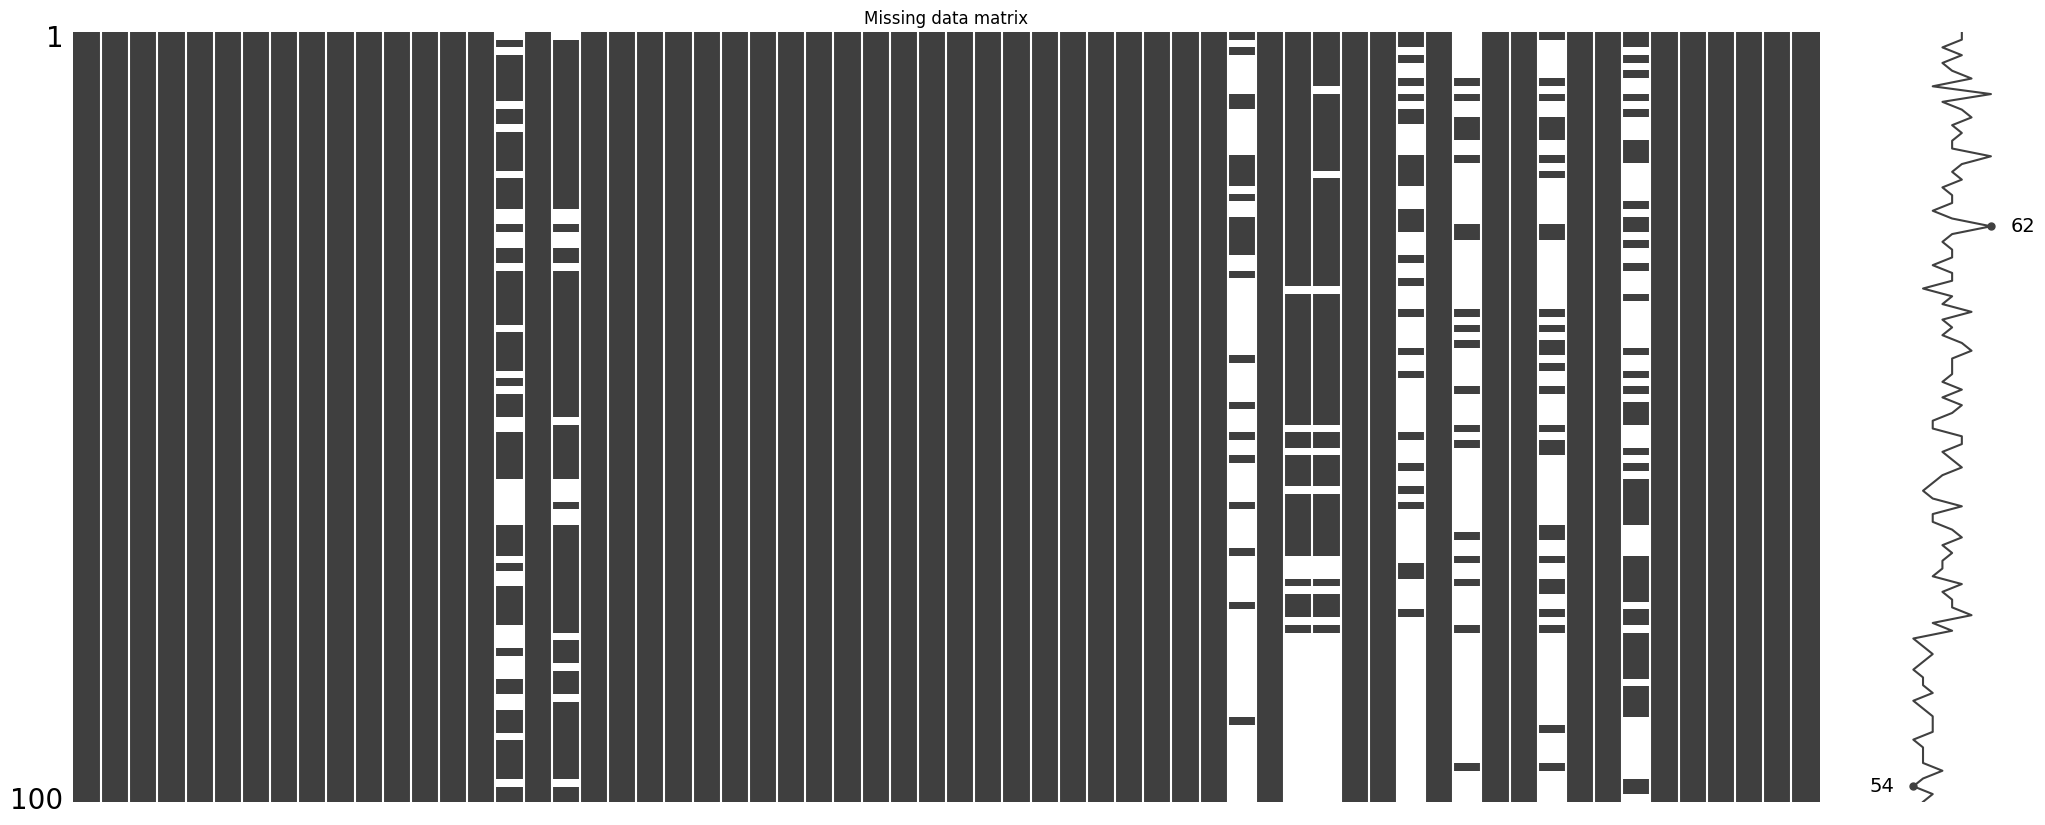

In [10]:
# Missing data visualization
msno.matrix(df)
plt.title("Missing data matrix")
plt.show()

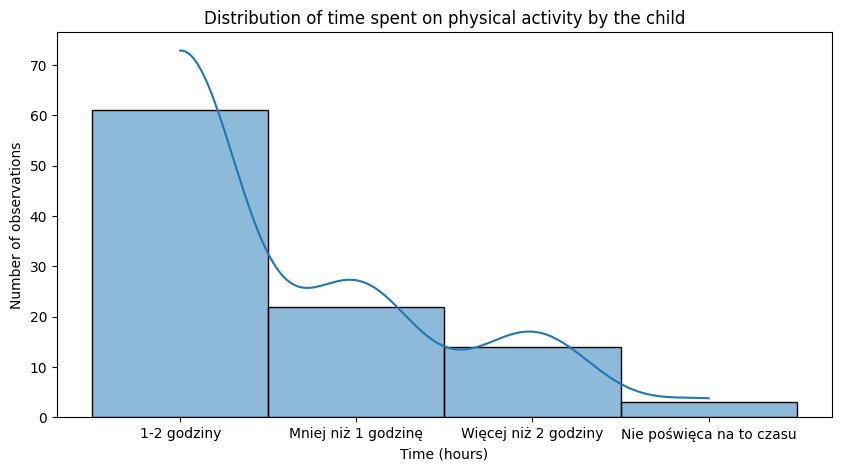

In [11]:
# Histogram of an example quantitative variable
plt.figure(figsize=(10, 5))
sns.histplot(df["Time spent on physical activity (child)"].dropna(), kde=True, bins=20)
plt.title("Distribution of time spent on physical activity by the child")
plt.xlabel("Time (hours)")
plt.ylabel("Number of observations")
plt.show()

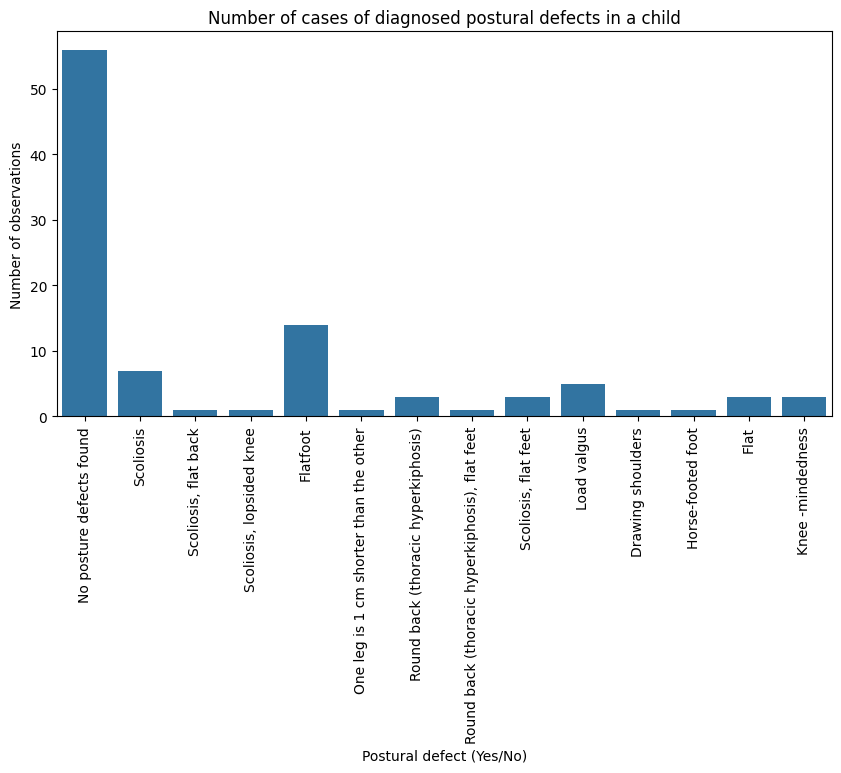

In [12]:
# Bar chart for a categorical variable (e.g., prevalence of postural defects)
plt.figure(figsize=(10, 5))
sns.countplot(x="Posture issues diagnosed (child)", data=df)
plt.title("Number of cases of diagnosed postural defects in a child")
plt.xlabel("Postural defect (Yes/No)")
plt.ylabel("Number of observations")
plt.xticks(rotation=90)
plt.show()

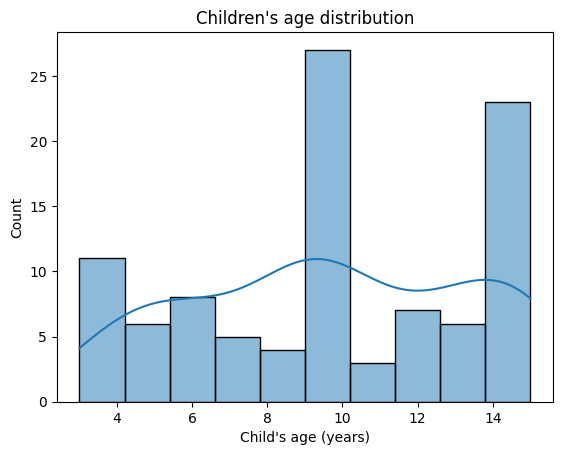

In [13]:
# Age distribution 
sns.histplot(df["Child's age (years)"], bins=10, kde=True)
plt.title("Children's age distribution")
plt.show()

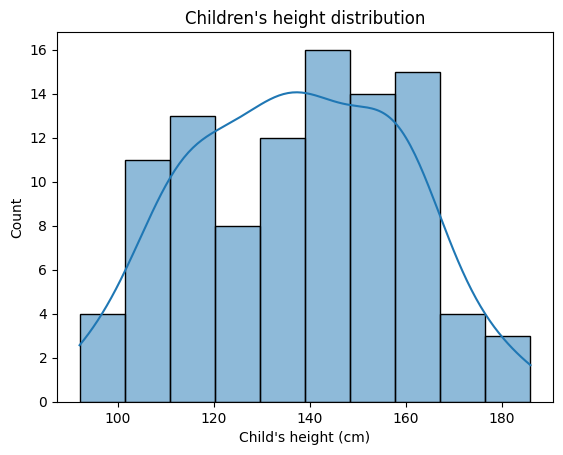

In [14]:
# Height distribution 
sns.histplot(df["Child's height (cm)"], bins=10, kde=True)
plt.title("Children's height distribution")
plt.show()

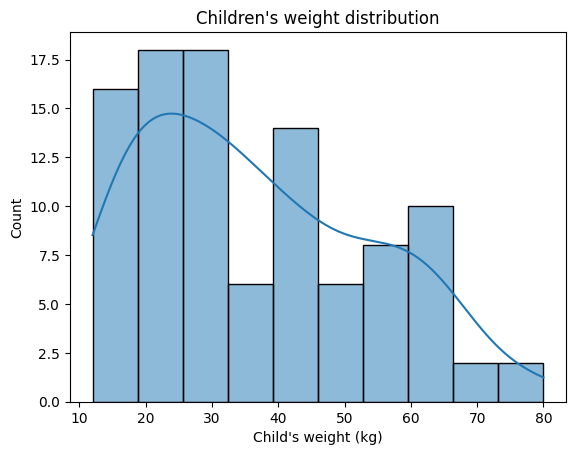

In [15]:
# Weight distribution 
sns.histplot(df["Child's weight (kg)"], bins=10, kde=True)
plt.title("Children's weight distribution")
plt.show()

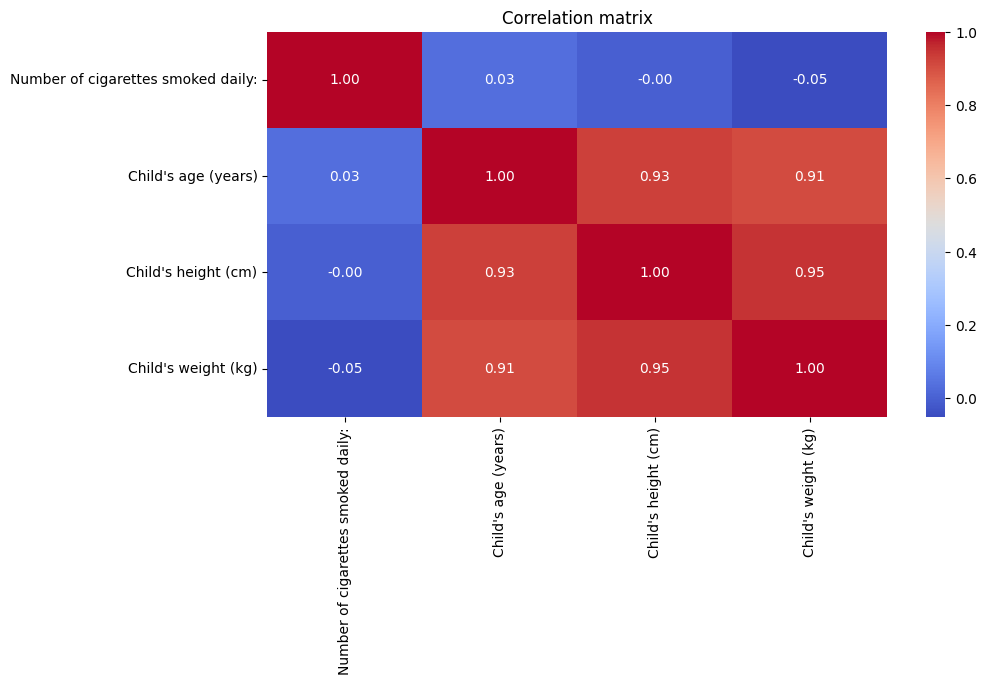

In [16]:
# Filter only numeric columns into the correlation matrix
numeric_cols = df.select_dtypes(include=["number"])

# Correlation matrix for numerical variables
plt.figure(figsize=(10, 5))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix")
plt.show()

In [17]:
# Checking the class distribution for the target variable (target)
print("Class distribution for 'Posture issues diagnosed (child)':")
print(df["Posture issues diagnosed (child)"].value_counts())

Class distribution for 'Posture issues diagnosed (child)':
Posture issues diagnosed (child)
No posture defects found                          56
Flatfoot                                          14
Scoliosis                                          7
Load valgus                                        5
Round back (thoracic hyperkiphosis)                3
Scoliosis, flat feet                               3
Flat                                               3
Knee -mindedness                                   3
Scoliosis, flat back                               1
Scoliosis, lopsided knee                           1
One leg is 1 cm shorter than the other             1
Round back (thoracic hyperkiphosis), flat feet     1
Horse-footed foot                                  1
Drawing shoulders                                  1
Name: count, dtype: int64


#### Data preparation (cleaning, imputation)

In [18]:
# Fill in the Null values
df.fillna({"Child's health issues, injuries, or surgeries:": "Unknown"}, inplace=True) 
df.fillna({"Actions taken to address diagnosed issues": "Unknown"}, inplace=True) 

# Deleting rows
df.drop(columns=["Timestamp", "Type of snacks (parent):", "Type of snacks (child):", "Do you smoke cigarettes?", 
                 "How do you understand 'healthy daily habits'?", "How do you understand 'unhealthy daily habits'?", 
                 "Initiatives supporting a healthy lifestyle and preventing posture issues:", 
                 "Which medications does the child take?", "Type of allergy", 
                 "Are there healthy lifestyle initiatives at school?", "Sources of information on healthy lifestyle:",
                 "Child's health issues, injuries, or surgeries:", "Does the child take medication?",
                 "Does the child regularly visit the dentist?", "Does the child have allergies?",
                 "Speech and hearing issues diagnosed (child)", "Place of residence", "Living conditions"], inplace=True) 

In [19]:
df.select_dtypes(include=["object"]).columns

Index(['Time spent on physical activity (parent)',
       'Time spent on physical activity (child)',
       'Frequency of physical activity (parent)',
       'Frequency of physical activity (child)',
       'Types of physical activities (parent)',
       'Types of physical activities (child)',
       'Hobbies and free time activities (parent)',
       'Hobbies and free time activities (child)',
       'Knowledge of healthy lifestyle guidelines',
       'Do you eat meals at regular times?',
       'Does the child eat meals at regular times?',
       'How many meals do you eat daily?',
       'How many meals does the child eat daily?',
       'Do you eat snacks between meals?',
       'Does the child eat snacks between meals?', 'Your diet', 'Child's diet',
       'Do you know and follow water intake recommendations?',
       'Do you teach the child about water intake recommendations?',
       'How many liters of water do you drink daily?',
       'How many liters of water does the child 

###  Preparing data for modeling (coding of variables, standardization)

#### Transformation of object type columns

In [20]:
def check_unique_object_columns(df):
    """
    A function that checks the unique values for object column in a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze.
    
    """
    
    # Iterate through each column and retrieve unique values
    for column in df.select_dtypes(include=["object"]).columns:
        unique_values = df[column].unique()
        print(f"Unique values in the column '{column}': {unique_values}")

In [21]:
# Calling the function
check_unique_object_columns(df)

Unique values in the column 'Time spent on physical activity (parent)': ['Mniej niż 1 godzinę' '1-2 godziny' 'Nie poświęcam na to czasu'
 'Więcej niż 2 godziny']
Unique values in the column 'Time spent on physical activity (child)': ['1-2 godziny' 'Mniej niż 1 godzinę' 'Więcej niż 2 godziny'
 'Nie poświęca na to czasu']
Unique values in the column 'Frequency of physical activity (parent)': ['1 raz w tygodniu' 'Więcej niż 3 razy w tygodniu' '3 razy w tygodniu'
 '2 razy w tygodniu']
Unique values in the column 'Frequency of physical activity (child)': ['2 razy w tygodniu' '1 raz w tygodniu' 'Więcej niż 3 razy w tygodniu'
 '3 razy w tygodniu']
Unique values in the column 'Types of physical activities (parent)': ['Pilates' 'Spacer (minimum 6 tysięcy kroków), Jazda na rowerze'
 'Bieganie, Jazda na rowerze, Aerobik'
 'Spacer (minimum 6 tysięcy kroków), Jazda na rowerze, Taniec, Trening personalny'
 'Spacer (minimum 6 tysięcy kroków), Jazda na rowerze, Pływanie, Taniec'
 'Spacer (minimum 6 ty

In [22]:
# Map to convert text to numbers
time_mapping = {
    "Nie poświęcam na to czasu": 0,
    "Nie poświęca na to czasu": 0,
    "Mniej niż 1 godzinę": 0.5,
    "1 godzinę": 1,
    "1-2 godziny": 1.5,
    "Więcej niż 2 godziny": 2.5
}

frequency_mapping = {
    "1 raz w tygodniu": 1,
    "2 razy w tygodniu": 2,
    "2-3 razy w tygodniu": 2.5,
    "3 razy w tygodniu": 3,
    "Więcej niż 3 razy w tygodniu": 4,
    "4-5 razy w tygodniu": 4.5,
    "Więcej niż 5 razy w tygodniu": 6
}

yes_no_mapping = {
    "Tak": 1,
    "Nie": 0,
    "Unknown": -1
}

meal_frequency_mapping = {
     "1 posiłek dziennie": 1,
     "2-3 posiłków dziennie": 2.5,
     "3-5 posiłków dziennie": 4,
     "Powyżej 5 posiłków dziennie": 5
}

water_frequency_mapping = {
    "Mniej niż 1 litr": 0.75,
    "1-1,5 litra": 1.25,
    "1,5-2 litrów": 1.75,
    "2 litry i więcej":  2.5  
}

drinks_frequency_mapping = {
     "Nie pijemy słodkich napojów, lub pijemy sporadycznie": 0,
     "Dziecko nie pije słodkich napojów, lub pije sporadycznie": 0,
     "1 raz w tygodniu": 1,
     "2-3 razy w tygodniu": 2.5,
     "3-5 razy w tygodniu": 4,
     "Więcej niż 5 razy w tygodniu": 5.5 
 }

alcohol_consumption_mapping = {
    "Nie spożywamy alkoholu": 0,
    "Raz na kilka miesięcy": 0.25,
    "Raz w miesiącu": 1,
    "Więcej niż raz w miesiącu": 2,
    "Raz w tygodniu": 4,
    "Więcej niż raz w tygodniu": 6
}

health_satisfaction_mapping = {
    "Bardzo dobrze": 3,
    "Dobrze": 2,
    "Raczej źle": 1
}

gender_mapping = {
    "Kobieta": 0,
    "Mężczyzna": 1
}

In [23]:
# Column transformation
df["Time spent on physical activity (parent)"] = df["Time spent on physical activity (parent)"].map(time_mapping)
df["Time spent on physical activity (child)"] = df["Time spent on physical activity (child)"].map(time_mapping)
df["Time spent outdoors with the child (daily)"] = df["Time spent outdoors with the child (daily)"].map(time_mapping)
df["Time spent by the child in front of screens (daily)"] = df["Time spent by the child in front of screens (daily)"].map(time_mapping)

df["Frequency of physical activity (parent)"] = df["Frequency of physical activity (parent)"].map(frequency_mapping)
df["Frequency of physical activity (child)"] = df["Frequency of physical activity (child)"].map(frequency_mapping)
df["Screen time frequency (child, weekly)"] = df["Screen time frequency (child, weekly)"].map(frequency_mapping)

df["Knowledge of healthy lifestyle guidelines"] = df["Knowledge of healthy lifestyle guidelines"].map(yes_no_mapping)
df["Do you eat meals at regular times?"] = df["Do you eat meals at regular times?"].map(yes_no_mapping)
df["Does the child eat meals at regular times?"] = df["Does the child eat meals at regular times?"].map(yes_no_mapping)
df["Do you eat snacks between meals?"] = df["Do you eat snacks between meals?"].map(yes_no_mapping)
df["Does the child eat snacks between meals?"] = df["Does the child eat snacks between meals?"].map(yes_no_mapping)
df["Do you know and follow water intake recommendations?"] = df["Do you know and follow water intake recommendations?"].map(yes_no_mapping)
df["Do you teach the child about water intake recommendations?"] = df["Do you teach the child about water intake recommendations?"].map(yes_no_mapping)
df["Do you pay attention to the child's sleeping position and mattress?"] = df["Do you pay attention to the child's sleeping position and mattress?"].map(yes_no_mapping)
df["Do you monitor the child's posture during learning and screen time?"] = df["Do you monitor the child's posture during learning and screen time?"].map(yes_no_mapping)
df["Actions taken to address diagnosed issues"] = df["Actions taken to address diagnosed issues"].map(yes_no_mapping)

df["How many meals do you eat daily?"] = df["How many meals do you eat daily?"].map(meal_frequency_mapping)
df["How many meals does the child eat daily?"] = df["How many meals does the child eat daily?"].map(meal_frequency_mapping)

df["How many liters of water do you drink daily?"] = df["How many liters of water do you drink daily?"].map(water_frequency_mapping)
df["How many liters of water does the child drink daily?"] = df["How many liters of water does the child drink daily?"].map(water_frequency_mapping)

df["How often do you drink sugary drinks weekly?"] = df["How often do you drink sugary drinks weekly?"].map(drinks_frequency_mapping)
df["How often does the child drink sugary drinks weekly?"] = df["How often does the child drink sugary drinks weekly?"].map(drinks_frequency_mapping)

df["How often do you drink alcoholic beverages?"] = df["How often do you drink alcoholic beverages?"].map(alcohol_consumption_mapping)

df["Assessment of health, well-being, and life satisfaction (parent):"] = df["Assessment of health, well-being, and life satisfaction (parent):"].map(health_satisfaction_mapping)
df["Assessment of child's health and overall satisfaction:"] = df["Assessment of child's health and overall satisfaction:"].map(health_satisfaction_mapping)

df["Child's gender"] = df["Child's gender"].map(gender_mapping)

In [24]:
object_columns = ["Types of physical activities (parent)", "Types of physical activities (child)", "Hobbies and free time activities (parent)", 
"Hobbies and free time activities (child)", "Your diet", "Child's diet", "How is your sleep hygiene?", "How is the child's sleep hygiene?",
"Statements about child's screen time and learning posture:", "Statements about the child's school backpack use:", "Causes of posture issues:",
"Factors influencing proper posture:"]

def process_columns_with_label_encoding(df, columns):
    """
    Processes the indicated columns in the DataFrame using Label Encoding.

    For each column in the `columns` list, the function performs the following operations:
    - Checks if the column exists in the DataFrame.
    - Applies Label Encoding to the values in the column, treating them as unique labels.
    - Handles NaN values, converting them to “Unknown”.
    - The transformed values are stored in a new column with the suffix '_encoded'.
    - Returns the transformed DataFrame and a dictionary of LabelEncoder objects for each column.

    If the column does not exist, the function displays an error message.

    Args:
        df (pandas.DataFrame): DataFrame to process.
        columns (list): List of column names to be encoded.

    Returns:
        tuple: Contains the processed DataFrame and LabelEncoders dictionary.
    """

    label_encoders = {}
    
    for col in columns:
        if col in df.columns:
            
            le = LabelEncoder()
            df[f"{col}_encoded"] = le.fit_transform(df[col].apply(lambda x: str(x).split(", ")[0] if pd.notnull(x) else "Unknown"))
            
            label_encoders[col] = le
        else:
            print(f"Column '{col}' not found in DataFrame.")
    
    return df, label_encoders

# Wywołanie funkcji
df, label_encoders = process_columns_with_label_encoding(df, object_columns)

#### Standardization

In [25]:
numeric_cols = df.select_dtypes(include=["number"])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_cols.columns])
df[numeric_cols.columns] = scaled_features

In [26]:
df["target_column"] = df["Posture issues diagnosed (child)"].apply(
    lambda x: 0 if x == "No posture defects found" else 1)

#### Data visualization 

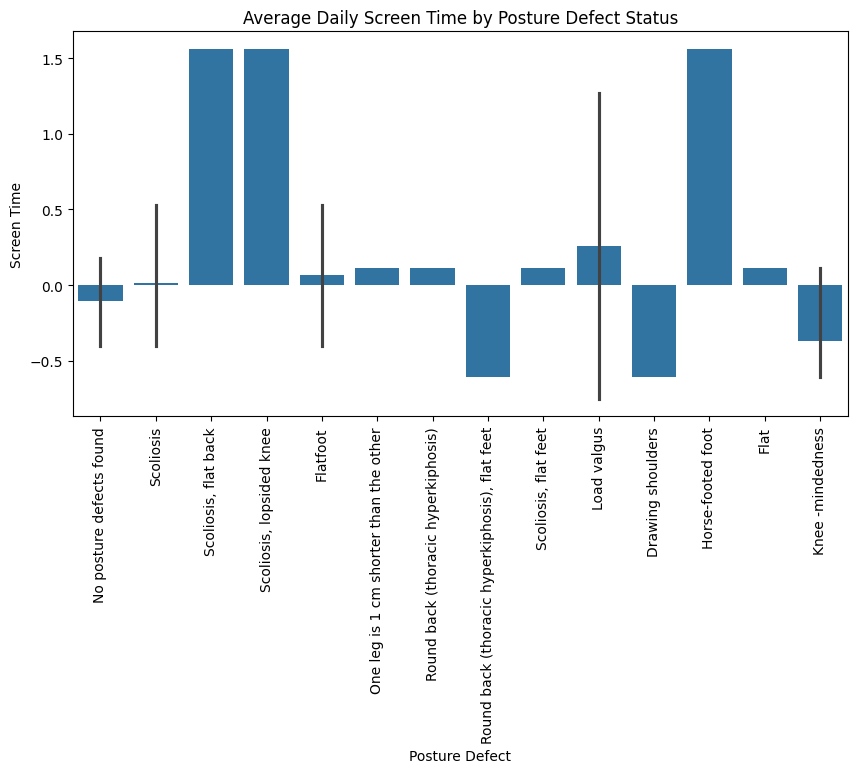

In [27]:
# Hypothesis-driven bar plot (screen time vs. defects)
plt.figure(figsize=(10, 5))
sns.barplot(x="Posture issues diagnosed (child)", y="Time spent by the child in front of screens (daily)", data=df)
plt.title("Average Daily Screen Time by Posture Defect Status")
plt.xlabel("Posture Defect")
plt.ylabel("Screen Time")
plt.xticks(rotation=90)
plt.show()

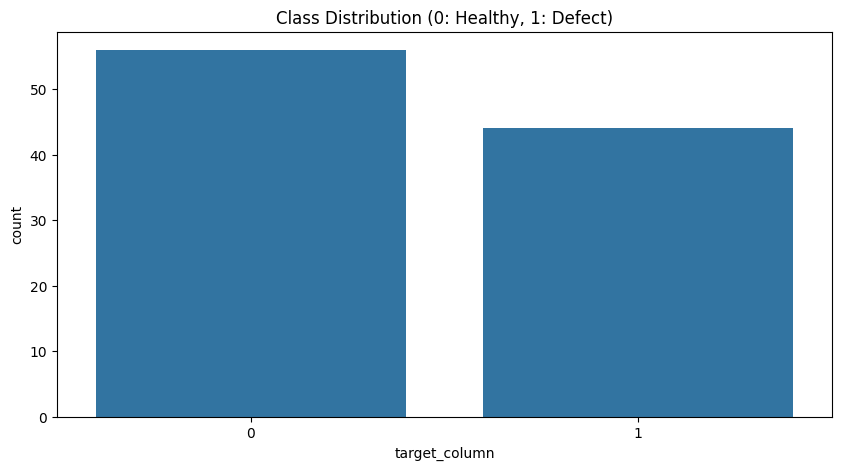

In [28]:
# Distribution of defects (class imbalance check)
plt.figure(figsize=(10, 5))
sns.countplot(x="target_column", data=df)
plt.title("Class Distribution (0: Healthy, 1: Defect)")
plt.show()

In [29]:
# Figures statistics for numeric columns
df.describe()

Time spent on physical activity (parent)  \
count                              1.000000e+02   
mean                               6.217249e-17   
std                                1.005038e+00   
min                               -1.401770e+00   
25%                               -6.600928e-01   
50%                               -6.600928e-01   
75%                                8.232618e-01   
max                                2.306616e+00   

       Time spent on physical activity (child)  \
count                             1.000000e+02   
mean                             -2.220446e-17   
std                               1.005038e+00   
min                              -2.142496e+00   
25%                              -1.947723e-01   
50%                               1.947723e-01   
75%                               1.947723e-01   
max                               1.752951e+00   

       Frequency of physical activity (parent)  \
count                             1.000000e+02   
mean                             -2.031708e-16   
std                               1.005038e+00   
min                              -1.363737e+00   
25%                              -1.363737e+00   
50%                               2.597594e-01   
75%                               1.071508e+00   
max                               1.071508e+00   

       Frequency of physical activity (child)  \
count                            1.000000e+02   
mean                            -2.187833e-16   
std                              1.005038e+00   
min                             -1.779981e+00   
25%                             -8.855183e-01   
50%                              8.944630e-03   
75%                              9.034076e-01   
max                              9.034076e-01   

       Knowledge of healthy lifestyle guidelines  \
count                               1.000000e+02   
mean                                1.776357e-17   
std                                 1.005038e+00   
min                                -1.779513e+00   
25%                                 5.619515e-01   
50%                                 5.619515e-01   
75%                                 5.619515e-01   
max                                 5.619515e-01   

       Do you eat meals at regular times?  \
count                        1.000000e+02   
mean                         5.329071e-17   
std                          1.005038e+00   
min                         -1.250641e+00   
25%                         -1.250641e+00   
50%                          7.995901e-01   
75%                          7.995901e-01   
max                          7.995901e-01   

       Does the child eat meals at regular times?  \
count                                1.000000e+02   
mean                                -7.327472e-17   
std                                  1.005038e+00   
min                                 -1.829707e+00   
25%                                  5.465357e-01   
50%                                  5.465357e-01   
75%                                  5.465357e-01   
max                                  5.465357e-01   

       How many meals do you eat daily?  \
count                      1.000000e+02   
mean                      -1.709743e-16   
std                        1.005038e+00   
min                       -2.850373e+00   
25%                       -9.244455e-01   
50%                       -9.244455e-01   
75%                        1.001483e+00   
max                        1.001483e+00   

       How many meals does the child eat daily?  \
count                              1.000000e+02   
mean                               4.884981e-17   
std                                1.005038e+00   
min                               -1.477152e+00   
25%                               -1.477152e+00   
50%                                6.431617e-01   
75%                                6.431617e-01   
max                                2.056704e+00   

  

In [30]:
train = df.select_dtypes(include=["number"])

# Checking correlations between variables
train.corr()

Time spent on physical activity (parent)  \
Time spent on physical activity (parent)                                            1.000000   
Time spent on physical activity (child)                                             0.573499   
Frequency of physical activity (parent)                                             0.580863   
Frequency of physical activity (child)                                              0.390678   
Knowledge of healthy lifestyle guidelines                                           0.179913   
Do you eat meals at regular times?                                                  0.178063   
Does the child eat meals at regular times?                                          0.237396   
How many meals do you eat daily?                                                   -0.138842   
How many meals does the child eat daily?                                           -0.157311   
Do you eat snacks between meals?                                                   -0.137616   
Does the child eat snacks between meals?                                           -0.237915   
Do you know and follow water intake recommendat...                                  0.100786   
Do you teach the child about water intake recom...                                 -0.052951   
How many liters of water do you drink daily?                                        0.064494   
How many liters of water does the child drink d...                                  0.096598   
How often do you drink sugary drinks weekly?                                       -0.051674   
How often does the child drink sugary drinks we...                                 -0.123939   
How often do you drink alcoholic beverages?                                        -0.163009   
Number of cigarettes smoked daily:                                                 -0.182366   
Do you pay attention to the child's sleeping po...                                  0.045317   
Time spent outdoors with the child (daily)                                          0.058497   
Time spent by the child in front of screens (da...                                 -0.041597   
Screen time frequency (child, weekly)                                              -0.000214   
Do you monitor the child's posture during learn...                                  0.007270   
Assessment of health, well-being, and life sati...                                  0.452370   
Assessment of child's health and overall satisf...                                  0.413494   
Actions taken to address diagnosed issues                                           0.061874   
Child's gender                                                                     -0.004157   
Child's age (years)                                                                -0.243646   
Child's height (cm)                                                                -0.258309   
Child's weight (kg)                                                                -0.239655   
Types of physical activities (parent)_encoded                                       0.057652   
Types of physical activities (child)_encoded                                        0.104183   
Hobbies and free time activities (parent)_encoded                                   0.116972   
Hobbies and free time activities (child)_encoded                                    0.029597   
Your diet_encoded                                                                   0.041398   
Child's diet_encoded                                                               -0.125332   
How is your sleep hygiene?_encoded                                                  0.209560   
How is the child's sleep hygiene?_encoded                                          -0.126571   
Statements about child's screen time and learni...                                  0.107002   
Statements about the child's school backpack us...                                 -0.190940   
Causes of posture is

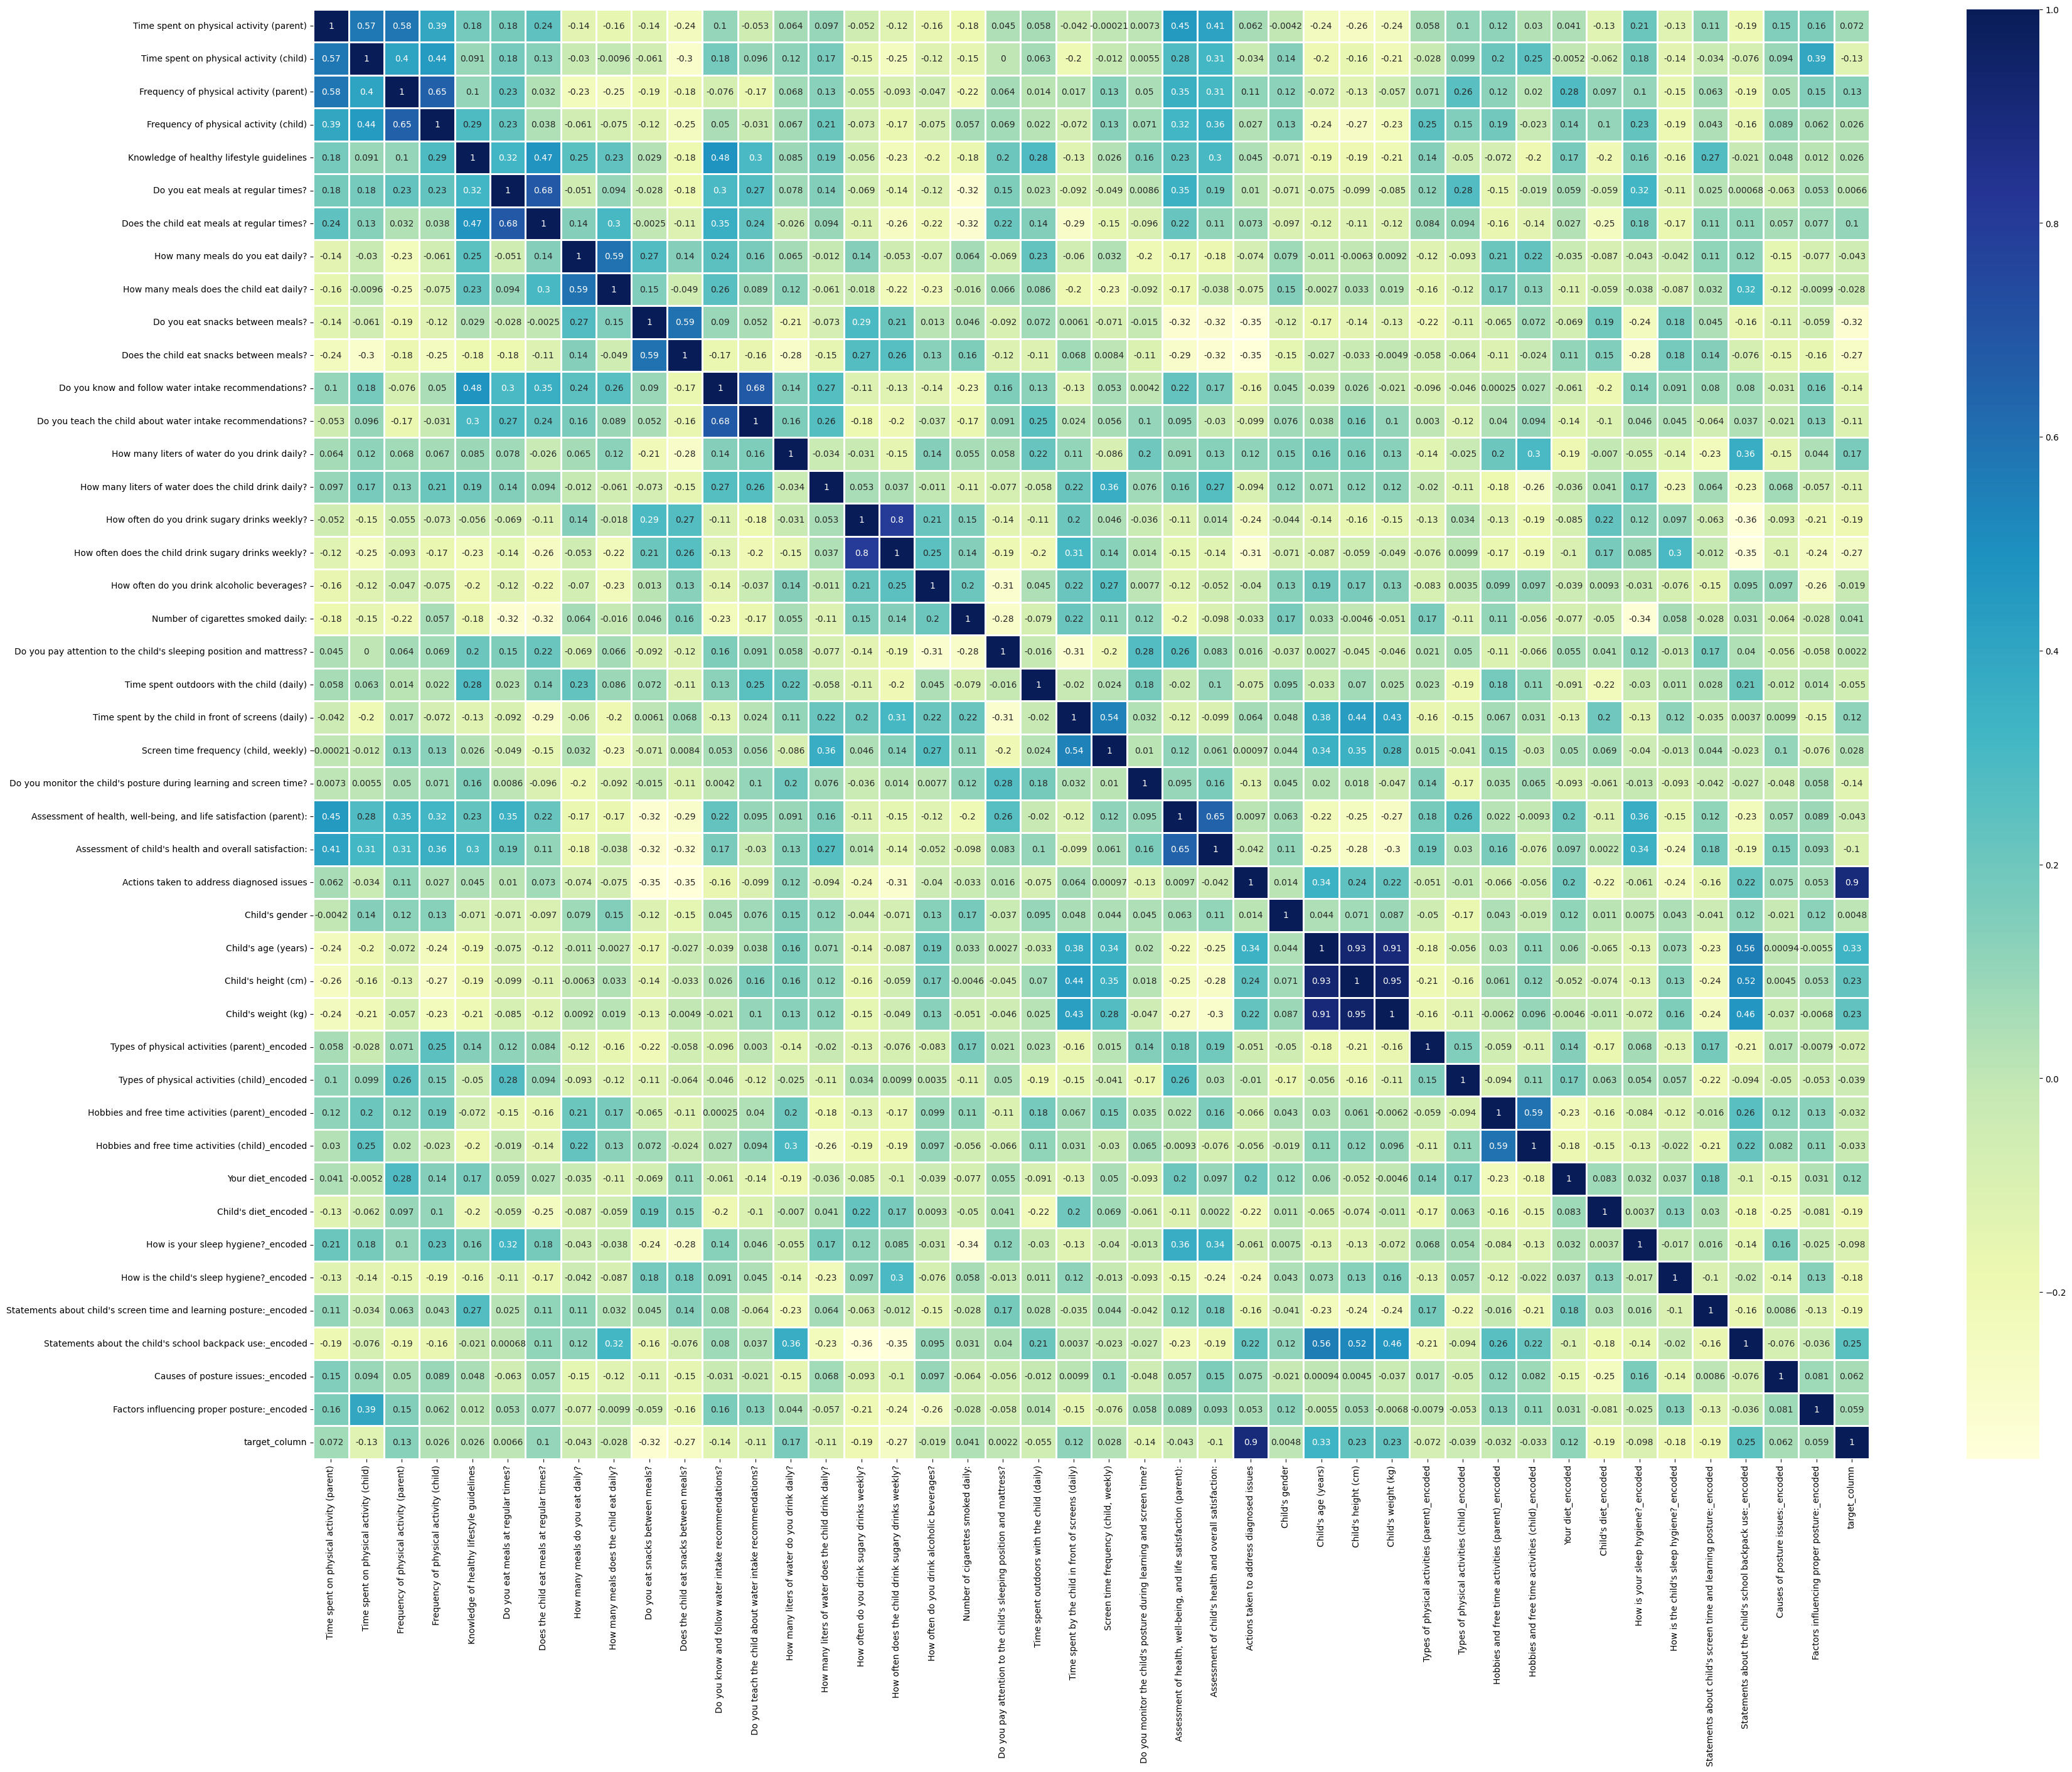

In [31]:
# Generating a heat map of correlation
plt.rcParams["figure.figsize"]=(40,30)
sns.heatmap(train.corr(), annot=True, linewidths=1, cmap="YlGnBu");

### Statistical analysis and hypothesis testing

Null hypothesis (H₀):
There is no statistically significant relationship between lifestyle (of parents and child) and the incidence of postural defects in a child.

Alternative hypothesis (H₁):
There is a statistically significant relationship between lifestyle (of parents and child) and the occurrence of postural defects in the child.

#### Chi-square test for categorical variablesanie

In [32]:
categorical_variables = ["Knowledge of healthy lifestyle guidelines",
                         "Do you eat meals at regular times?",
                         "Does the child eat meals at regular times?",
                         "Do you eat snacks between meals?",
                         "Does the child eat snacks between meals?",
                         "Do you know and follow water intake recommendations?",
                         "Do you teach the child about water intake recommendations?",
                         "Do you pay attention to the child's sleeping position and mattress?",
                         "Do you monitor the child's posture during learning and screen time?",
                         "Assessment of health, well-being, and life satisfaction (parent):",
                         "Assessment of child's health and overall satisfaction:",
                         "Actions taken to address diagnosed issues",
                         "Child's gender",
                         "Types of physical activities (parent)_encoded",
                         "Types of physical activities (child)_encoded",
                         "Hobbies and free time activities (parent)_encoded",
                         "Hobbies and free time activities (child)_encoded",
                         "Your diet_encoded",
                         "Child's diet_encoded",
                         "How is your sleep hygiene?_encoded",
                         "How is the child's sleep hygiene?_encoded",
                         "Statements about child's screen time and learning posture:_encoded",
                         "Statements about the child's school backpack use:_encoded",
                         "Causes of posture issues:_encoded",
                         "Factors influencing proper posture:_encoded"]

In [33]:
continuous_variables = ["Time spent on physical activity (parent)",
                        "Time spent on physical activity (child)",
                        "Frequency of physical activity (parent)",
                        "Frequency of physical activity (child)",
                        "How many meals do you eat daily?",
                        "How many meals does the child eat daily?",
                        "How many liters of water do you drink daily?",
                        "How many liters of water does the child drink daily?",
                        "How often do you drink sugary drinks weekly?",
                        "How often does the child drink sugary drinks weekly?",
                        "How often do you drink alcoholic beverages?",
                        "Number of cigarettes smoked daily:",
                        "Time spent outdoors with the child (daily)",
                        "Time spent by the child in front of screens (daily)",
                        "Screen time frequency (child, weekly)",
                        "Child's age (years)",
                        "Child's height (cm)",
                        "Child's weight (kg)"]

In [34]:
def chi_square_tests(df, columns, target, significance_level=0.05):
    """
    Performs a chi-square test for each specified column (except target) in the DataFrame,
    and computes a global chi-square result by summing individual test statistics.
    
    Displays only the chi-square test values: chi2, p-value, and degrees of freedom.
    
    Parameters:
    - df: DataFrame with data.
    - columns: list of the names of the columns that contain categorical data.
    - target: the target variable Series.
    - significance_level: significance level (default: 0.05).
    
    Returns:
    A dictionary with the individual test results and the global result.
    """
    results = {}  # Dictionary to store individual test results
    
    # Iterate through all columns in the DataFrame
    for col in columns:
        
        # Create a contingency table between the current column and the target variable
        contingency_table = pd.crosstab(df[col], target)
        
        # If the table is empty or there are not enough observations, we skip the
        if contingency_table.empty:
            print(f"Contingency table for the column '{col}' is empty - skipping.")
            continue
        
        # Conduct a chi-square test
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Record the results
        results[col] = {
            "chi2": chi2_stat,
            "p_value": p_value,
            "dof": dof,
        }
        
        # Display the test results
        print(f"\nChi-square test for the column '{col}':")
        print(f"χ² = {chi2_stat:.3f}, p-value = {p_value:.4f}, degrees of freedom = {dof}")
        if p_value < significance_level:
            print("=> There is a statistically significant relationship (we reject H₀).")
        else:
            print("=> No significant relationship (we do not reject H₀).")

    # Calculation of global statistics - we sum chi² statistics and degrees of freedom
    global_chi2 = sum(item["chi2"] for item in results.values())
    global_df = sum(item["dof"] for item in results.values())
    
    # Calculation of global p-value using the distribution of the chi-square distribution
    global_p_value = 1 - chi2.cdf(global_chi2, global_df)
    
    # View global results
    print("\n=== Global Chi-Square Result ===")
    print(f"Global χ²: {global_chi2:.3f}, global p-value: {global_p_value:.4f}, global degrees of freedom: {global_df}")
    if global_p_value < significance_level:
        print("=> Global test: There is a statistically significant relationship among the variables (reject H₀).")
    else:
        print("=> Global test: No statistically significant relationship (do not reject H₀).")
    
    # Adding global results to the results dictionary
    results["global"] = {
        "chi2": global_chi2,
        "p_value": global_p_value,
        "dof": global_df
    }
    
    return

In [35]:
def fisher_tests(data, columns, target, significance_level=0.05):
    """
    Performs Fisher exact test for each specified column (assumed to form 2x2 tables) in the DataFrame,
    and computes a global Fisher result by combining individual p-values using Fisher's method.
    
    Parameters:
    - df: DataFrame with data.
    - columns: list of the names of the 2x2 shaped columns that contain categorical data.
    - target: the target variable Series.
    - significance_level: significance level (default: 0.05).
    
    The function prints the test results for each column and the global result.
    """
    results = {}  # Dictionary to store individual test results
    p_values = []     # List to store individual p-values for combining later
    
    # Iterate through all columns in the DataFrame
    for col in columns:
        
        # Create a contingency table between the current column and the target variable
        contingency_table = pd.crosstab(df[col], df[target])
        
        # If the table is empty or there are not enough observations, we skip the
        if contingency_table.empty:
            print(f"Contingency table for the column '{col}' is empty - skipping.")
            continue
        
        # Conduct Fisher test
        odds_ratio, p_value_fisher = fisher_exact(contingency_table)

        # Record the results
        results[col] = {
            "odds_ratio": float(odds_ratio),
            "p_value": float(p_value_fisher)
        }
        p_values.append(p_value_fisher)
                
        # Display the test results for the current column
        print(f"\nFisher exact test for column '{col}':")
        print(f"Odds ratio = {odds_ratio:.3f}, p-value = {p_value_fisher:.4f}")
        if p_value_fisher < significance_level:
            print("The result of the test is statistically significant - we reject the null hypothesis.")
        else:
            print("No grounds for rejecting the null hypothesis.")

        # Compute global Fisher test using Fisher's method
    if p_values:
        # Calculate the combined test statistic: T = -2 * sum(log(p_i))
        T = -2 * np.sum(np.log(p_values))
        # Degrees of freedom = 2 * (number of tests)
        dof_global = 2 * len(p_values)
        # Global p-value from the chi-square distribution
        global_p_value = 1 - chi2.cdf(T, dof_global)
        
        print("\n=== Global Fisher Test Result (combined p-values using Fisher's method) ===")
        print(f"Combined test statistic = {T:.3f}, degrees of freedom = {dof_global}, global p-value = {global_p_value:.4f}")

        if global_p_value < significance_level:
            print("=> Global test: There is a statistically significant relationship among the variables (reject H₀).")
        else:
            print("=> Global test: No statistically significant relationship (do not reject H₀).")
        
        results["global"] = {
            "combined_statistic": T,
            "degrees_of_freedom": dof_global,
            "global_p_value": global_p_value
        }

    return 

In [36]:
def columns_for_fisher(df, columns, target):
    """
    For the given list of columns, it returns those that, after creating a contingency table with the target, 
    form a 2x2 table (that is, they have exactly 2 unique values and in combination with the target as well).

    Parameters:
    - df: DataFrame with data.
    - columns: list of column names to check.
    - target: the name or Series of the target variable.

    Returns:
    List of column names that meet the assumptions for the Fisher test.
    """
    valid_columns = []
    
    # Ensure that the target variable has exactly 2 unique values
    target_vals = df[target].dropna().unique() if isinstance(target, str) else target.dropna().unique()
    if len(target_vals) != 2:
        print(f"Warning: The target variable does not have 2 unique values (it has {len(target_vals)}.")
        return valid_columns
    
    for col in columns:
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) != 2:
            continue
        
        contingency_table = pd.crosstab(df[col], df[target] if isinstance(target, str) else target)
        if contingency_table.shape == (2, 2):
            valid_columns.append(col)
    
    return valid_columns

In [37]:
# Columns meeting the conditions of 2x2 for FIsher test
fisher_valid_columns = columns_for_fisher(df, categorical_variables, "target_column")

In [38]:
# Columns that are NOT suitable for Fisher
chi2_columns = [col for col in categorical_variables if col not in fisher_valid_columns]

In [39]:
fisher_tests(train, fisher_valid_columns, "target_column")


Fisher exact test for column 'Knowledge of healthy lifestyle guidelines':
Odds ratio = 1.133, p-value = 0.8183
No grounds for rejecting the null hypothesis.

Fisher exact test for column 'Do you eat meals at regular times?':
Odds ratio = 1.028, p-value = 1.0000
No grounds for rejecting the null hypothesis.

Fisher exact test for column 'Does the child eat meals at regular times?':
Odds ratio = 1.646, p-value = 0.3474
No grounds for rejecting the null hypothesis.

Fisher exact test for column 'Do you eat snacks between meals?':
Odds ratio = 0.249, p-value = 0.0016
The result of the test is statistically significant - we reject the null hypothesis.

Fisher exact test for column 'Does the child eat snacks between meals?':
Odds ratio = 0.205, p-value = 0.0116
The result of the test is statistically significant - we reject the null hypothesis.

Fisher exact test for column 'Do you know and follow water intake recommendations?':
Odds ratio = 0.441, p-value = 0.2332
No grounds for rejecting 

In [40]:
chi_square_tests(train, chi2_columns, df["Posture issues diagnosed (child)"])


Chi-square test for the column 'Assessment of health, well-being, and life satisfaction (parent):':
χ² = 41.466, p-value = 0.0278, degrees of freedom = 26
=> There is a statistically significant relationship (we reject H₀).

Chi-square test for the column 'Assessment of child's health and overall satisfaction:':
χ² = 77.019, p-value = 0.0000, degrees of freedom = 26
=> There is a statistically significant relationship (we reject H₀).

Chi-square test for the column 'Actions taken to address diagnosed issues':
χ² = 85.634, p-value = 0.0000, degrees of freedom = 26
=> There is a statistically significant relationship (we reject H₀).

Chi-square test for the column 'Types of physical activities (parent)_encoded':
χ² = 118.827, p-value = 0.1518, degrees of freedom = 104
=> No significant relationship (we do not reject H₀).

Chi-square test for the column 'Types of physical activities (child)_encoded':
χ² = 61.380, p-value = 0.9169, degrees of freedom = 78
=> No significant relationship (w

#### Comparison of averages for a continuous variable

In [41]:
def check_normality(df, columns, significance_level=0.05):
    """
    Checks the normality distribution for the given continuous columns using the Shapiro-Wilk test.
    
    Parameters:
    - df: DataFrame containing the data.
    - columns: list of continuous column names.
    - significance_level: significance level (default is 0.05).
    
    Returns:
    A dictionary where each column contains:
      - 'shapiro_stat': Shapiro-Wilk test statistic,
      - 'p_value': p-value,
      - 'normal': True if p_value > significance_level (i.e., normality is not rejected), False otherwise.
    """
    results = {}
    for col in columns:
        data = df[col].dropna()
        if data.empty:
            print(f"Column '{col}' contains no data - skipping.")
            continue
        stat, p = shapiro(data)
        is_normal = p > significance_level
        results[col] = {"shapiro_stat": stat, "p_value": p, "normal": is_normal}
        print(f"Column '{col}': Shapiro-Wilk p-value = {p:.4f} => {'normal' if is_normal else 'non-normal'}")
    print()  # empty line for clarity
    return results

In [45]:
def perform_stat_tests(df, continuous_columns, target, significance_level=0.05):
    """
     Performs statistical tests for the given continuous columns based on normality.
    - If `target` has 2 groups: Uses t-test (parametric) or Mann-Whitney U test (non-parametric).
    - If `target` has more than 2 groups: Uses ANOVA (parametric) or Kruskal-Wallis test (non-parametric).
    
    Also includes:
    - Fisher's method for global significance across all individual tests.

    Parameters:
    - df: DataFrame containing the data.
    - continuous_columns: list of continuous column names.
    - target: name of the grouping column (target variable).
    - significance_level: significance level (default is 0.05).

    Prints individual test results, global Fisher's test, and MANOVA results.
    """
    # First, check normality for the given continuous columns
    norm_results = check_normality(df, continuous_columns, significance_level)
    
    # Determine unique groups in the target variable (ignoring missing values)
    groups = df[target].dropna().unique()
    num_groups = len(groups)

    if num_groups < 2:
        print("The target variable lacks a sufficient number of groups for comparison.")
        return

    p_values = []  # Store p-values for Fisher's test
    
    for col in continuous_columns:
        print(f"Statistical tests for column '{col}':")
        # Retrieve data for each group
        group_data = [df[df[target] == g][col].dropna() for g in groups]
        
        # Check if the column was determined to be normally distributed
        is_normal = norm_results.get(col, {}).get("normal", False)
        
        if num_groups == 2:
            # For two groups
            if is_normal:
                # Parametric Student’s t-test
                t_stat, p_value = ttest_ind(group_data[0], group_data[1])
                test_name = "Student's t-test"
            else:
                # Non-parametric Mann-Whitney U test
                t_stat, p_value = mannwhitneyu(group_data[0], group_data[1])
                test_name = "Mann-Whitney U test"
        else:
            # For more than two groups
            if is_normal:
                # Parametric ANOVA test
                t_stat, p_value = f_oneway(*group_data)
                test_name = "ANOVA"
            else:
                # Non-parametric Kruskal-Wallis test
                t_stat, p_value = kruskal(*group_data)
                test_name = "Kruskal-Wallis test"

        p_values.append(p_value)  # Save the p-value
        
        print(f"{test_name}: statistic = {t_stat:.3f}, p-value = {p_value:.4f}")
        if p_value < significance_level:
            print("=> Significant difference between groups (reject H₀).")
        else:
            print("=> No significant difference between groups (fail to reject H₀).")
        print()  # empty line for clarity

        # Visual analysis: histogram with KDE and Q-Q plot
        plt.figure(figsize=(12, 5))
        
        # Histogram with KDE
        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), kde=True, bins=20)
        plt.title(f"Histogram with KDE for '{col}'")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        
        # Q-Q plot
        plt.subplot(1, 2, 2)
        sm.qqplot(df[col].dropna(), line='s', ax=plt.gca())
        plt.title(f"Q-Q Plot for '{col}'")
        
        plt.tight_layout()
        plt.show()

    # Compute global Fisher's test
    if len(p_values) > 1:
        T, global_p_value = combine_pvalues(p_values, method='fisher')
        print(f"Global Fisher’s Test: T = {T:.3f}, p-value = {global_p_value:.4f}")
    
        if global_p_value < significance_level:
            print("=> Significant difference between groups globally (reject H₀).")
        else:
            print("=> No significant difference between groups globally (fail to reject H₀).")

Column 'Time spent on physical activity (parent)': Shapiro-Wilk p-value = 0.0000 => non-normal
Column 'Time spent on physical activity (child)': Shapiro-Wilk p-value = 0.0000 => non-normal
Column 'Frequency of physical activity (parent)': Shapiro-Wilk p-value = 0.0000 => non-normal
Column 'Frequency of physical activity (child)': Shapiro-Wilk p-value = 0.0000 => non-normal
Column 'How many meals do you eat daily?': Shapiro-Wilk p-value = 0.0000 => non-normal
Column 'How many meals does the child eat daily?': Shapiro-Wilk p-value = 0.0000 => non-normal
Column 'How many liters of water do you drink daily?': Shapiro-Wilk p-value = 0.0000 => non-normal
Column 'How many liters of water does the child drink daily?': Shapiro-Wilk p-value = 0.0000 => non-normal
Column 'How often do you drink sugary drinks weekly?': Shapiro-Wilk p-value = 0.0000 => non-normal
Column 'How often does the child drink sugary drinks weekly?': Shapiro-Wilk p-value = 0.0000 => non-normal
Column 'How often do you drink

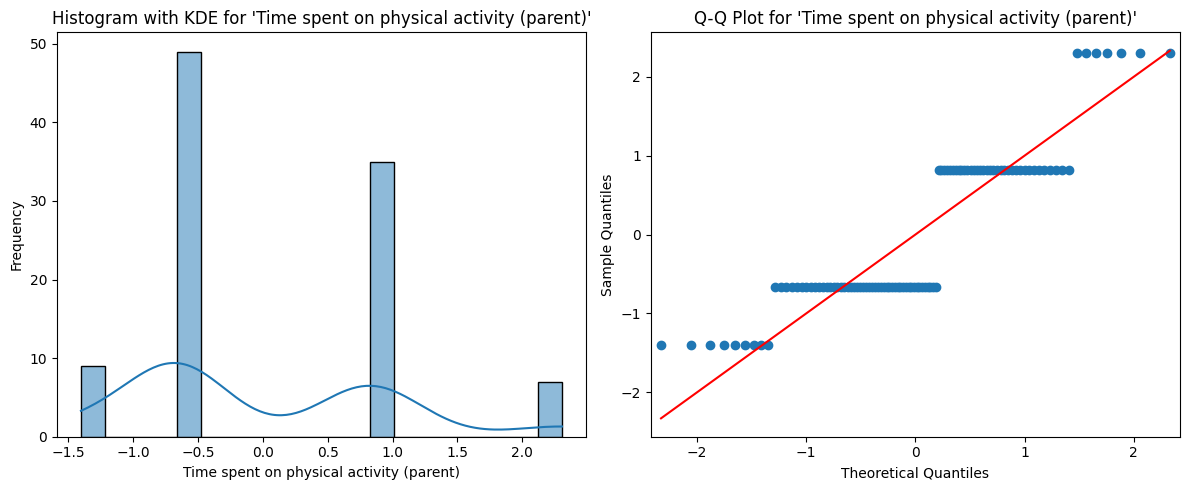

Statistical tests for column 'Time spent on physical activity (child)':
Mann-Whitney U test: statistic = 1379.500, p-value = 0.2415
=> No significant difference between groups (fail to reject H₀).



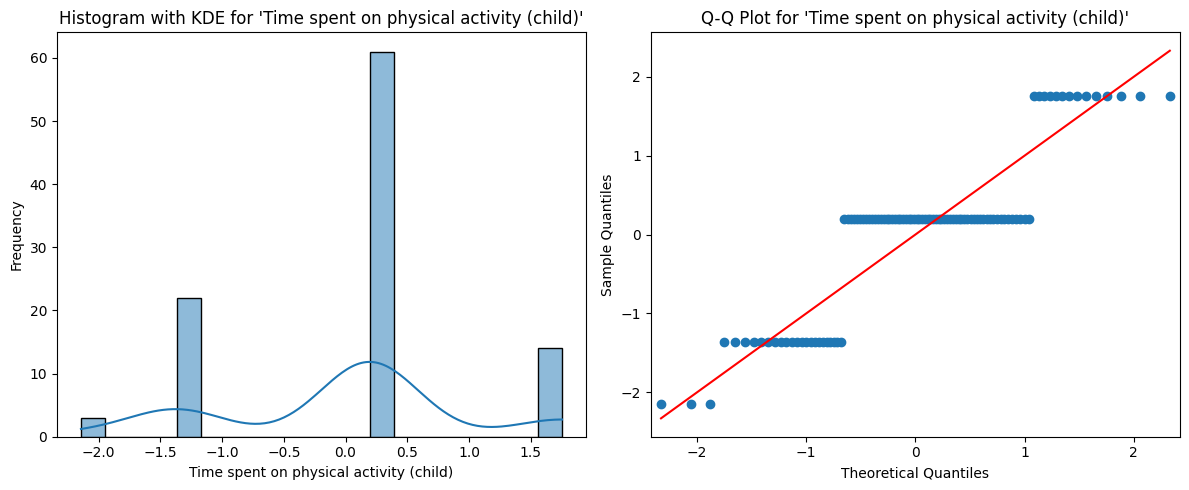

Statistical tests for column 'Frequency of physical activity (parent)':
Mann-Whitney U test: statistic = 1043.000, p-value = 0.1711
=> No significant difference between groups (fail to reject H₀).



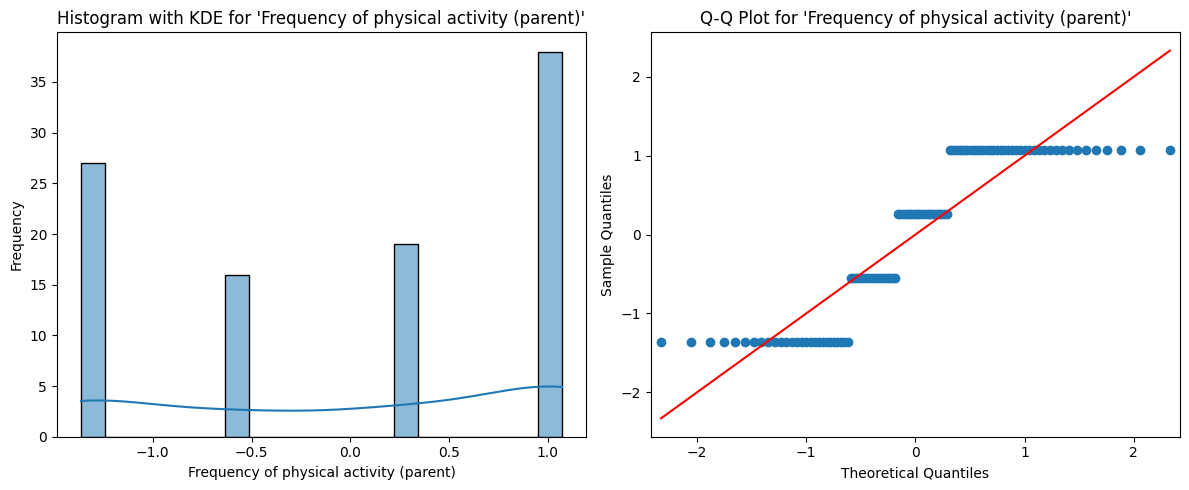

Statistical tests for column 'Frequency of physical activity (child)':
Mann-Whitney U test: statistic = 1184.500, p-value = 0.7278
=> No significant difference between groups (fail to reject H₀).



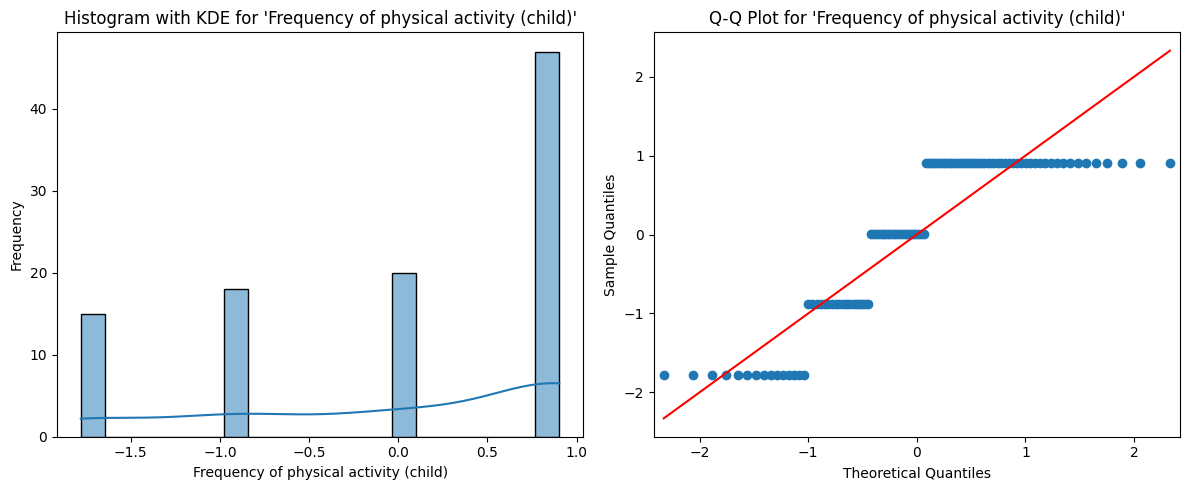

Statistical tests for column 'How many meals do you eat daily?':
Mann-Whitney U test: statistic = 1298.000, p-value = 0.6012
=> No significant difference between groups (fail to reject H₀).



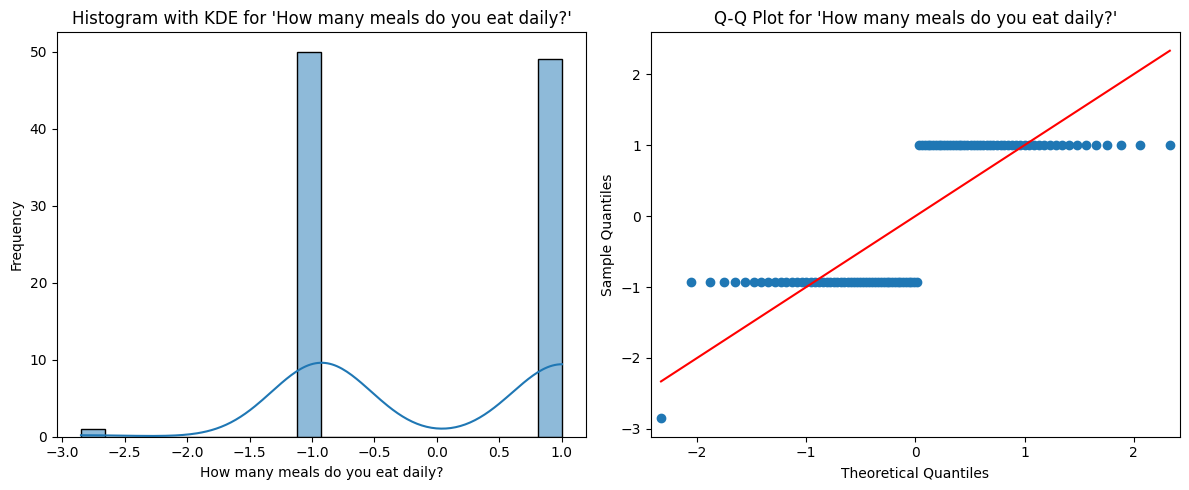

Statistical tests for column 'How many meals does the child eat daily?':
Mann-Whitney U test: statistic = 1265.000, p-value = 0.7805
=> No significant difference between groups (fail to reject H₀).



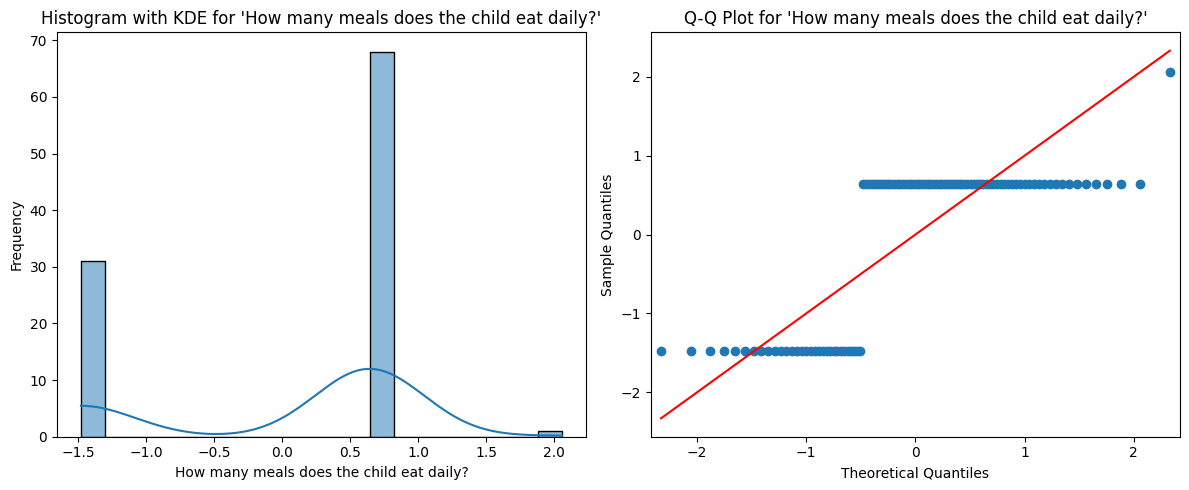

Statistical tests for column 'How many liters of water do you drink daily?':
Mann-Whitney U test: statistic = 996.000, p-value = 0.0870
=> No significant difference between groups (fail to reject H₀).



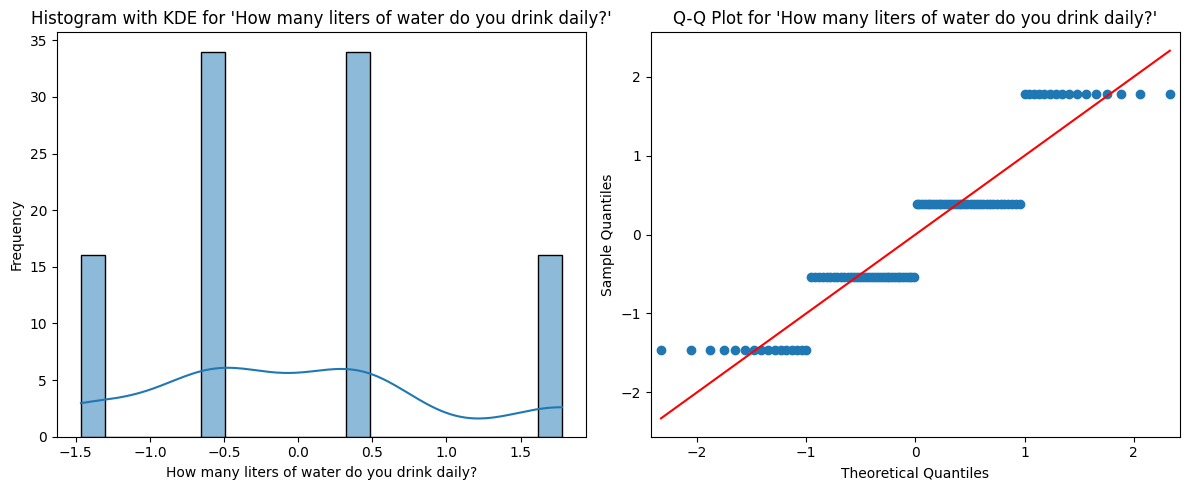

Statistical tests for column 'How many liters of water does the child drink daily?':
Mann-Whitney U test: statistic = 1352.000, p-value = 0.3492
=> No significant difference between groups (fail to reject H₀).



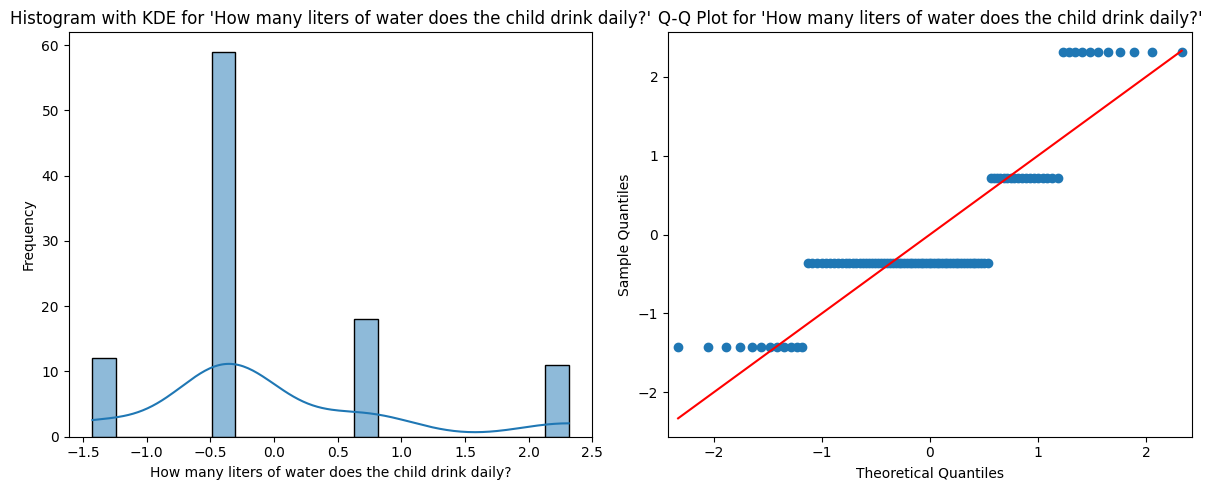

Statistical tests for column 'How often do you drink sugary drinks weekly?':
Mann-Whitney U test: statistic = 1610.500, p-value = 0.0061
=> Significant difference between groups (reject H₀).



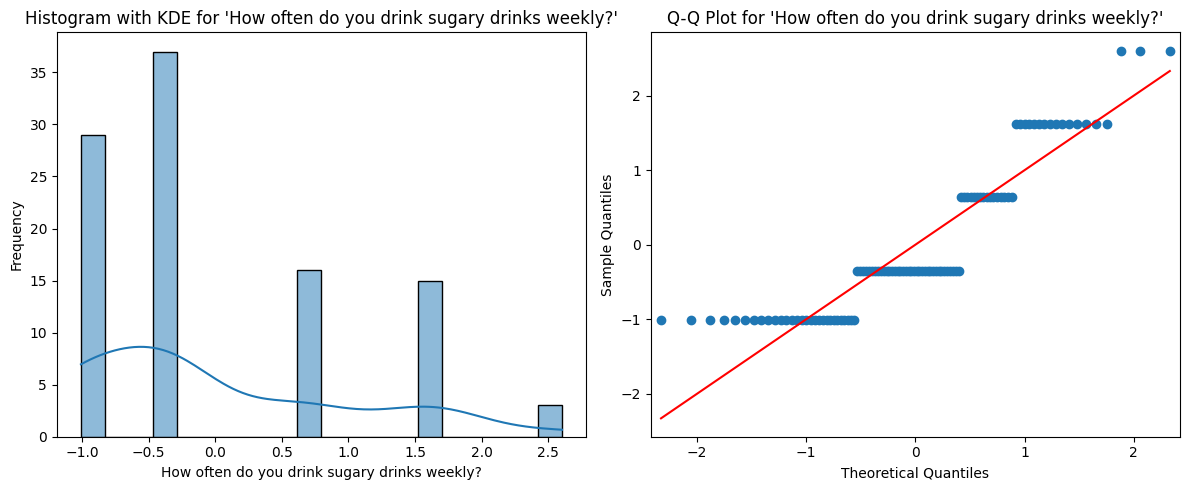

Statistical tests for column 'How often does the child drink sugary drinks weekly?':
Mann-Whitney U test: statistic = 1722.000, p-value = 0.0004
=> Significant difference between groups (reject H₀).



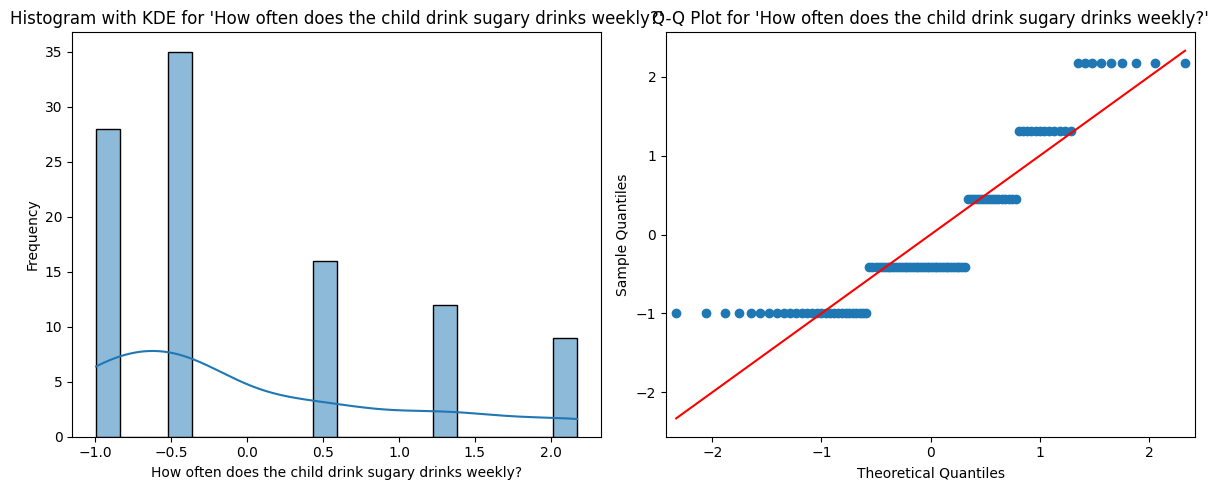

Statistical tests for column 'How often do you drink alcoholic beverages?':
Mann-Whitney U test: statistic = 1315.500, p-value = 0.5547
=> No significant difference between groups (fail to reject H₀).



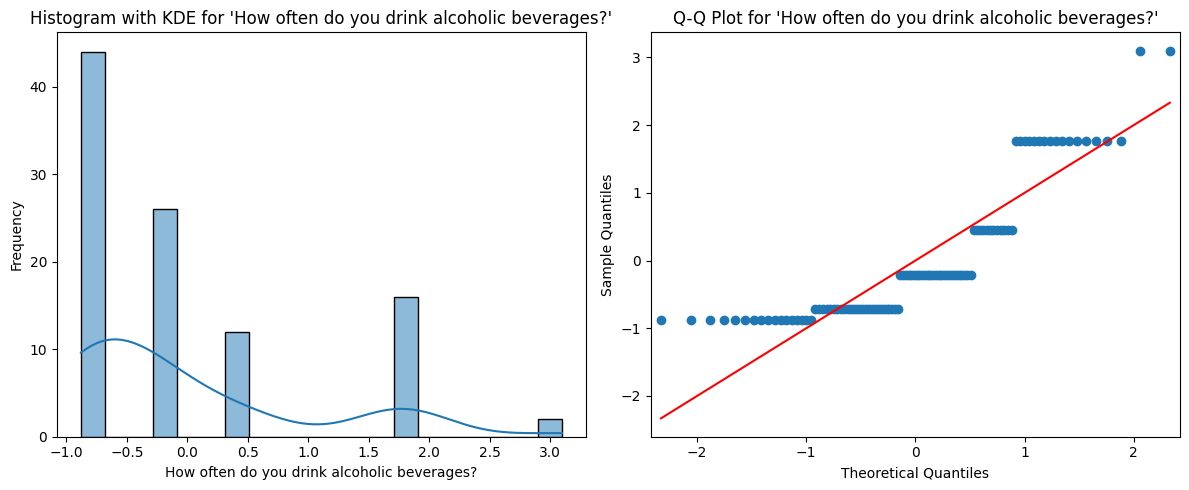

Statistical tests for column 'Number of cigarettes smoked daily:':
Mann-Whitney U test: statistic = 1174.500, p-value = 0.4980
=> No significant difference between groups (fail to reject H₀).



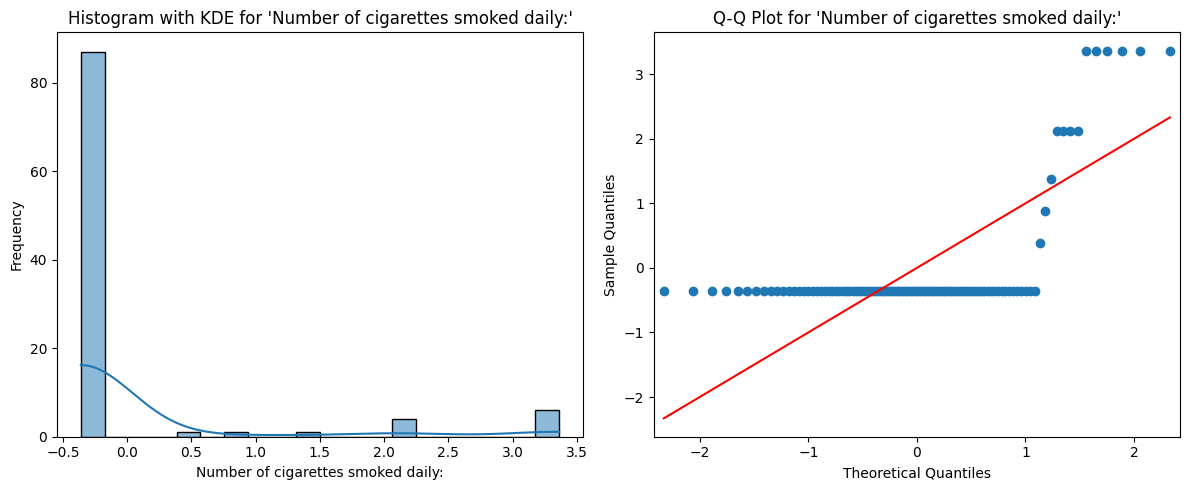

Statistical tests for column 'Time spent outdoors with the child (daily)':
Mann-Whitney U test: statistic = 1295.000, p-value = 0.6457
=> No significant difference between groups (fail to reject H₀).



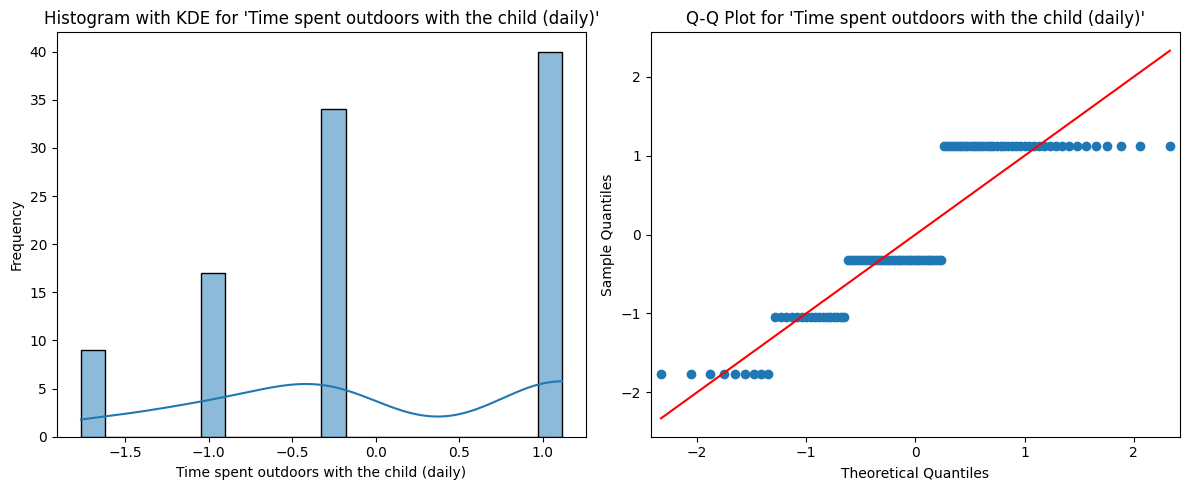

Statistical tests for column 'Time spent by the child in front of screens (daily)':
Mann-Whitney U test: statistic = 1082.000, p-value = 0.2758
=> No significant difference between groups (fail to reject H₀).



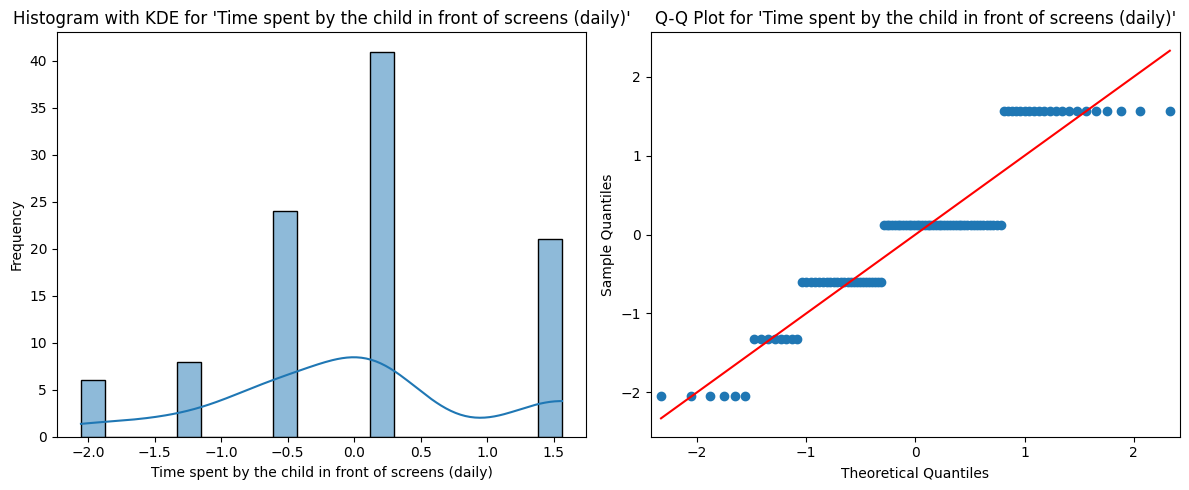

Statistical tests for column 'Screen time frequency (child, weekly)':
Mann-Whitney U test: statistic = 1239.000, p-value = 0.9620
=> No significant difference between groups (fail to reject H₀).



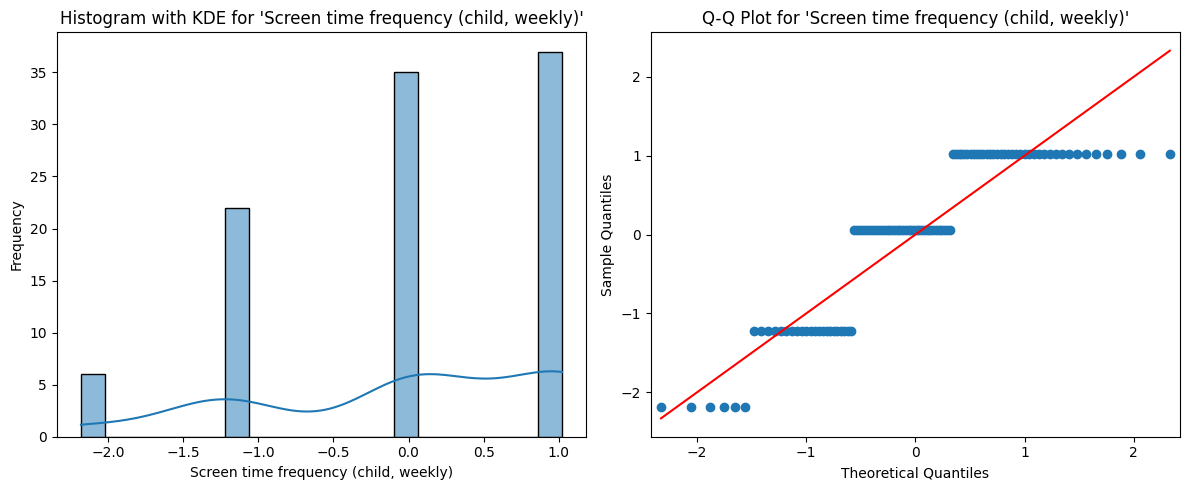

Statistical tests for column 'Child's age (years)':
Mann-Whitney U test: statistic = 759.000, p-value = 0.0010
=> Significant difference between groups (reject H₀).



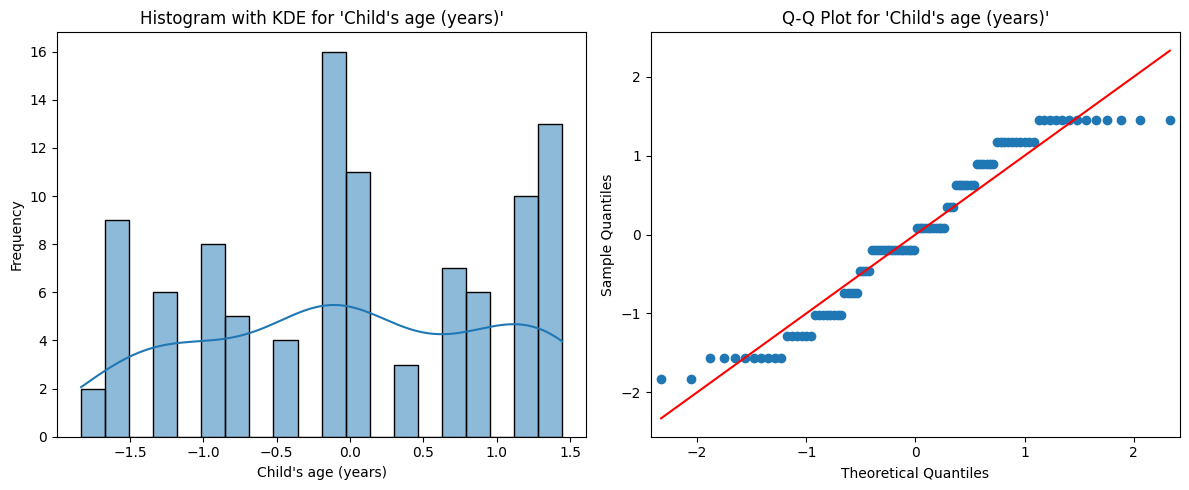

Statistical tests for column 'Child's height (cm)':
Student's t-test: statistic = -2.308, p-value = 0.0231
=> Significant difference between groups (reject H₀).



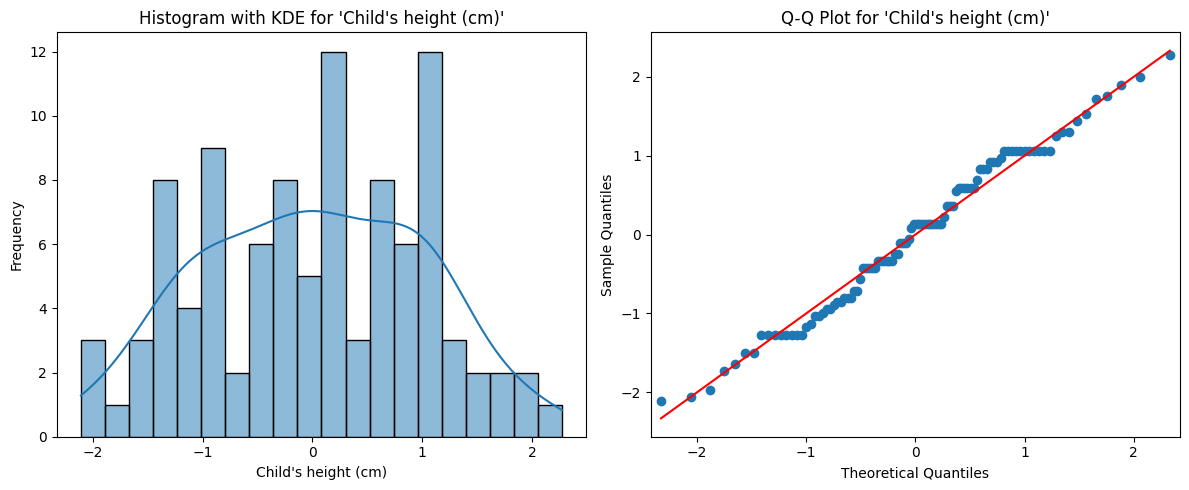

Statistical tests for column 'Child's weight (kg)':
Mann-Whitney U test: statistic = 862.000, p-value = 0.0102
=> Significant difference between groups (reject H₀).



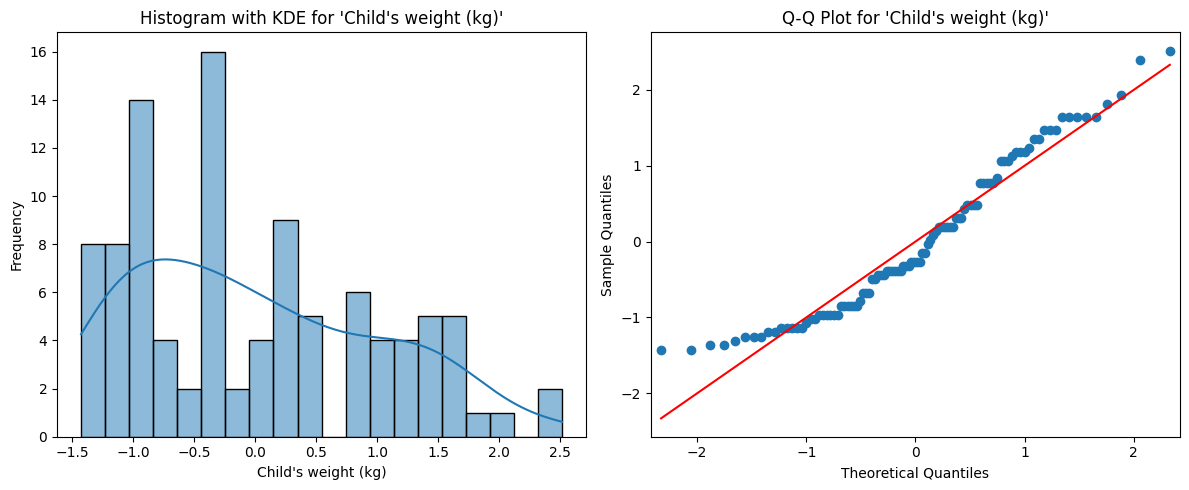

Global Fisher’s Test: T = 78.877, p-value = 0.0000
=> Significant difference between groups globally (reject H₀).


In [46]:
perform_stat_tests(train, continuous_variables, "target_column")

In [47]:
import statsmodels.api as sm

temp = train.copy()

continuous_variables_names = {"Time spent on physical activity (parent)":"Time_spent_on_physical_activity_parent",
                        "Time spent on physical activity (child)":"Time_spent_on_physical_activity_child",
                        "Frequency of physical activity (parent)":"Frequency_of_physical_activity_parent",
                        "Frequency of physical activity (child)":"Frequency_of_physical_activity_child",
                        "How many meals do you eat daily?":"How_many_meals_do_you_eat_daily",
                        "How many meals does the child eat daily?":"How_many_meals_does_the_child_eat_daily",
                        "How many liters of water do you drink daily?":"How_many_liters_of_water_do_you_drink_daily",
                        "How many liters of water does the child drink daily?":"How_many_liters_of_water_does_the_child_drink_daily",
                        "How often do you drink sugary drinks weekly?":"How_often_do_you_drink_sugary_drinks_weekly",
                        "How often does the child drink sugary drinks weekly?":"How_often_does_the_child_drink_sugary_drinks_weekly",
                        "How often do you drink alcoholic beverages?":"How_often_do_you_drink_alcoholic_beverages",
                        "Number of cigarettes smoked daily:":"Number_of_cigarettes_smoked_daily",
                        "Time spent outdoors with the child (daily)":"Time_spent_outdoors_with_the_child_daily",
                        "Time spent by the child in front of screens (daily)":"Time_spent_by_the_child_in_front_of_screens_daily",
                        "Screen time frequency (child, weekly)":"Screen_time_frequency_child_weekly",
                        "Child's age (years)":"Child_age_years",
                        "Child's height (cm)":"Child_height_cm",
                        "Child's weight (kg)":"Child_weight_kg"}

# Application of new column names for MANOVA
temp.rename(columns=continuous_variables_names, inplace=True)

continuous_variables_for_manova = [
    "Time_spent_on_physical_activity_parent", 
    "Time_spent_on_physical_activity_child",
    "Frequency_of_physical_activity_parent",
    "Frequency_of_physical_activity_child",
    "How_many_meals_do_you_eat_daily",
    "How_many_meals_does_the_child_eat_daily",
    "How_many_liters_of_water_do_you_drink_daily",
    "How_many_liters_of_water_does_the_child_drink_daily",
    "How_often_do_you_drink_sugary_drinks_weekly",
    "How_often_does_the_child_drink_sugary_drinks_weekly",
    "How_often_do_you_drink_alcoholic_beverages",
    "Number_of_cigarettes_smoked_daily",
    "Time_spent_outdoors_with_the_child_daily",
    "Time_spent_by_the_child_in_front_of_screens_daily",
    "Screen_time_frequency_child_weekly",
    "Child_age_years",
    "Child_height_cm",
    "Child_weight_kg"
]

# Convert target to string
temp["target_column"] = temp["target_column"].astype(str)

# Creating a formula
formula = " + ".join(continuous_variables_for_manova) + " ~ target_column"

# Conducting MANOVA
manova = MANOVA.from_formula(formula, temp)
print(manova.mv_test())

                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value   Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.8314 18.0000 81.0000  0.9123 0.5662
         Pillai's trace 0.1686 18.0000 81.0000  0.9123 0.5662
 Hotelling-Lawley trace 0.2027 18.0000 81.0000  0.9123 0.5662
    Roy's greatest root 0.2027 18.0000 81.0000  0.9123 0.5662
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
     target_column      Value   Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.6846 18.0000 81.0000  2.0734 0.0142
         Pillai's trace 0.3154 18.0000 81.0000  2.0734 0.0142
 Hotelling-Lawley trace 0.

### Modeling (machine learning)

In [48]:
X = train.drop("target_column", axis=1)
y = train["target_column"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
# Create a dictionary of models to test
models = {
    "DummyClassifier": DummyClassifier(strategy="most_frequent"),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

In [52]:
# Model results
results = {}

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [107]:
# For confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    plt.figure(figsize=(4,4))
    ax = plt.gca()
    
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                            cmap=plt.cm.Blues, 
                                            normalize="true", 
                                            ax=ax,
                                            colorbar=False,  # Remove colorbar to save space
                                           )
    plt.title(f"{model_name} Confusion Matrix")
    plt.tight_layout()  # Optimize spacing
    plt.show()

# For learning curves
def plot_learning_curve(estimator, title, X, y, cv=None):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='accuracy'
    )
    
    plt.figure(figsize=(6,3))
    plt.title(title)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Cross-validation score")
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.tight_layout()  # Optimize spacing
    plt.show()

# For features importance
def plot_feature_importances(model, feature_names, title):
    try:
        # For tree-based models
        importances = model.feature_importances_
    except AttributeError:
        try:
            # For linear models
            importances = np.abs(model.coef_[0])
        except AttributeError:
            print(f"No feature importances available for {type(model).__name__}")
            return
    
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()


Model: DummyClassifier
Accuracy: 0.6333
ROC-AUC: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        19
           1       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.32      0.50      0.39        30
weighted avg       0.40      0.63      0.49        30

Confusion Matrix:
[[19  0]
 [11  0]]
Cross-Validation Scores: [0.5        0.5        0.5        0.57142857 0.57142857]
Mean CV Accuracy: 0.5286


C:\Users\KejPis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\KejPis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\KejPis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

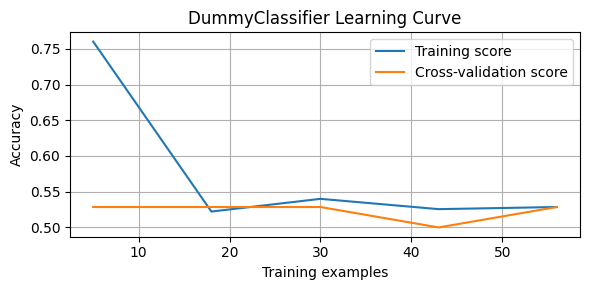

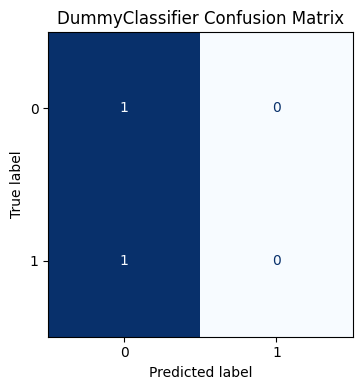


Model: LogisticRegression
Accuracy: 0.8333
ROC-AUC: 0.8301
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       0.75      0.82      0.78        11

    accuracy                           0.83        30
   macro avg       0.82      0.83      0.82        30
weighted avg       0.84      0.83      0.83        30

Confusion Matrix:
[[16  3]
 [ 2  9]]
Cross-Validation Scores: [0.85714286 0.92857143 0.85714286 0.78571429 0.92857143]
Mean CV Accuracy: 0.8714


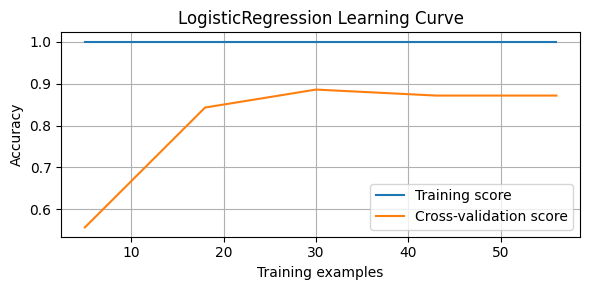

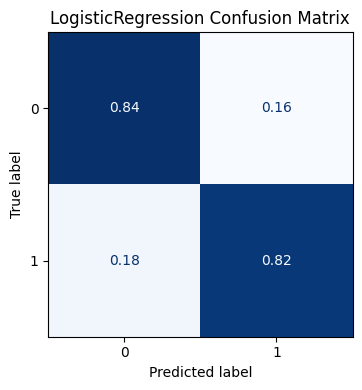

C:\Users\KejPis\AppData\Local\Temp\ipykernel_22112\4170919200.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


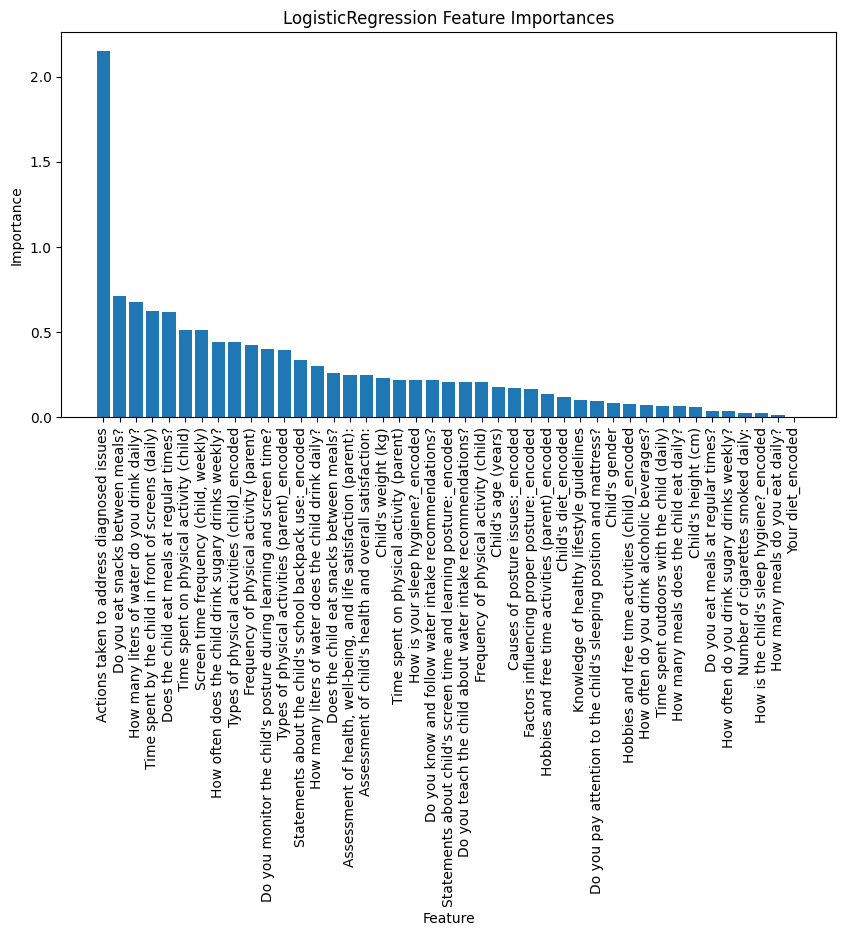


Model: DecisionTree
Accuracy: 0.8333
ROC-AUC: 0.8493
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86        19
           1       0.71      0.91      0.80        11

    accuracy                           0.83        30
   macro avg       0.83      0.85      0.83        30
weighted avg       0.86      0.83      0.84        30

Confusion Matrix:
[[15  4]
 [ 1 10]]
Cross-Validation Scores: [0.85714286 0.92857143 0.85714286 0.85714286 0.92857143]
Mean CV Accuracy: 0.8857


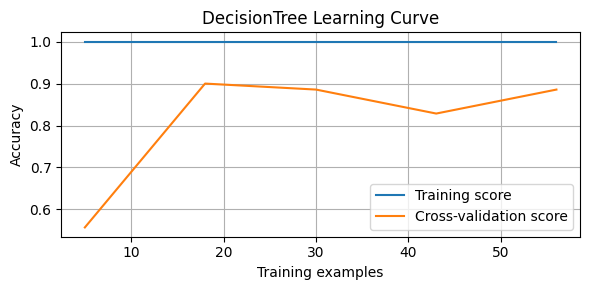

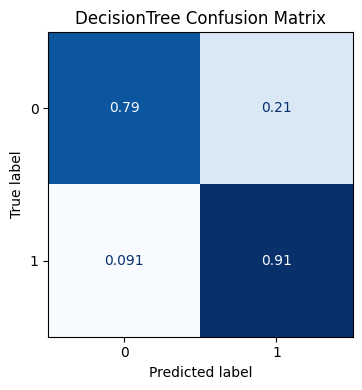

C:\Users\KejPis\AppData\Local\Temp\ipykernel_22112\4170919200.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


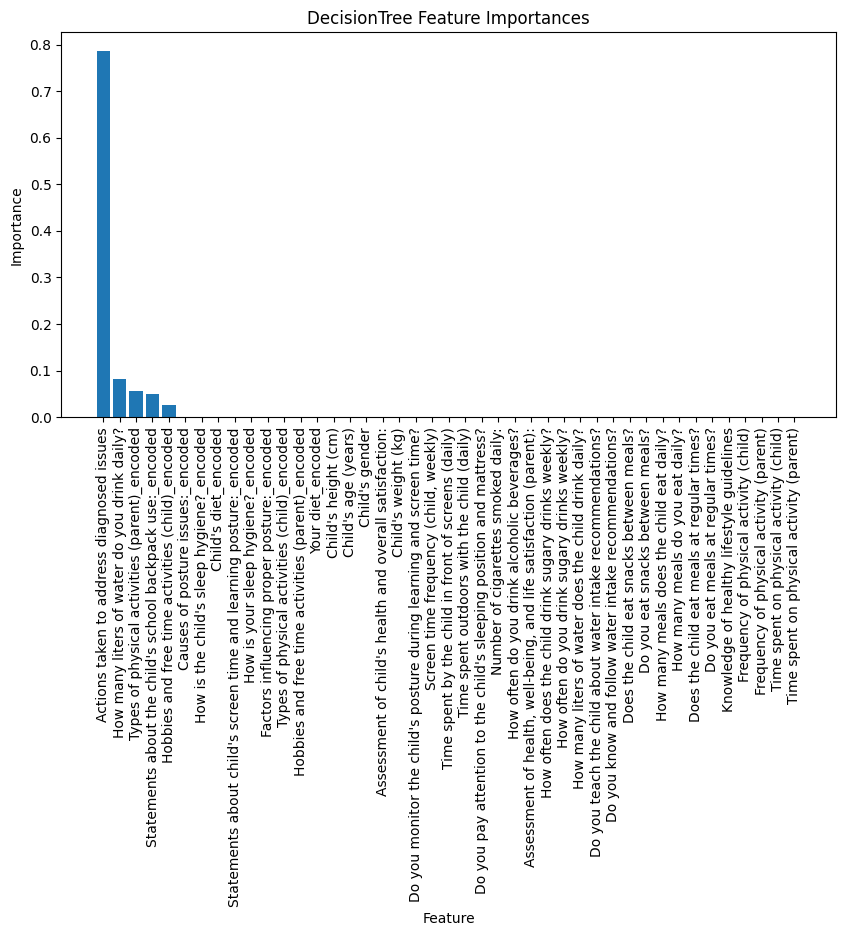


Model: RandomForest
Accuracy: 0.9000
ROC-AUC: 0.9019
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.83      0.91      0.87        11

    accuracy                           0.90        30
   macro avg       0.89      0.90      0.89        30
weighted avg       0.90      0.90      0.90        30

Confusion Matrix:
[[17  2]
 [ 1 10]]
Cross-Validation Scores: [0.85714286 0.85714286 0.85714286 0.92857143 0.92857143]
Mean CV Accuracy: 0.8857


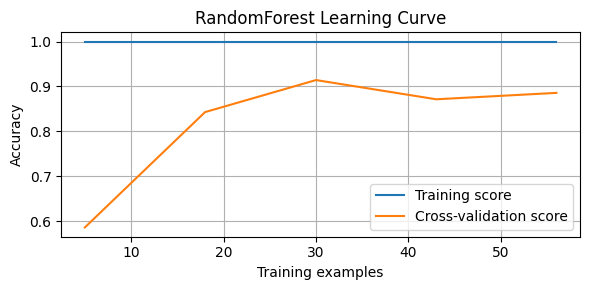

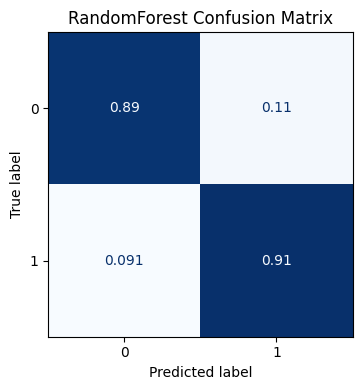

C:\Users\KejPis\AppData\Local\Temp\ipykernel_22112\4170919200.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


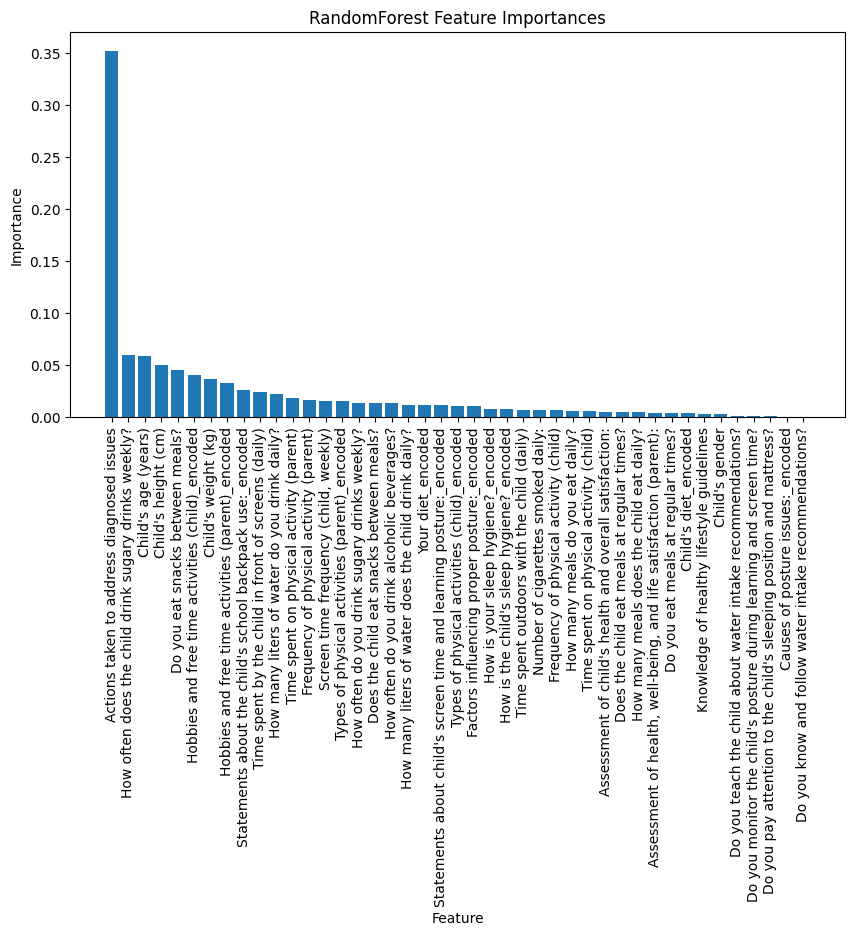

In [108]:
# Testing each model
for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    
    # Training the model
    model.fit(X_train, y_train)
    
    # Prediction
    y_pred = model.predict(X_test)
    
    # Evaluation of the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    
    # Displaying the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Classification Report:\n{class_report}")
    print(f"Confusion Matrix:\n{confusion}")
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
    
    # Recording the results 
    results[model_name] = {
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "cv_scores": cv_scores,
        "cv_mean_accuracy": cv_scores.mean()
    }

    # ===== Visualization Section =====
    # Learning Curve
    plot_learning_curve(model, f"{model_name} Learning Curve", X_train, y_train, cv=kf)
    
    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, model_name)

    # Feature Importances (for models that support it)
    if hasattr(model, 'feature_importances_') or hasattr(model, 'coef_'):
        plot_feature_importances(model, X_train.columns, f"{model_name} Feature Importances")
    
    plt.close('all')  # Clean up figures to prevent memory issue

In [67]:
results_df = pd.DataFrame.from_dict(results, orient="index")

# Round numeric columns to 4 decimal places
numeric_cols = ["accuracy", "roc_auc", "cv_mean_accuracy"]
results_df[numeric_cols] = results_df[numeric_cols].round(4)

# Convert `cv_scores` arrays to strings with rounded values
results_df["cv_scores"] = results_df["cv_scores"].apply(
    lambda arr: f"[{', '.join(f'{x:.4f}' for x in arr)}]"
)

def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: #c7c7c7" if v else "" for v in is_max]

styled_df = results_df.style.apply(highlight_max, subset=numeric_cols)
styled_df

### Conclusion and summary